In [7]:
!pip install keras_tuner

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score, precision_score, recall_score
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
from math import pi
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

In [9]:
# **Objective 1: Data Acquisition and Intelligent Preprocessing**

# **Dataset Acquisition:** Download the "Diabetes Health Indicators Dataset" from Kaggle.
# Access to Relevant Datasets: "Diabetes Health Indicators Dataset" from Kaggle:
# https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

# Data Loading
print("Loading the Diabetes Health Indicators Dataset...")
data = pd.read_csv('Data/diabetes_binary_health_indicators_BRFSS2015.csv')
print("Dataset loaded successfully!")

# **Data Inspection:** Conduct initial data inspection to understand data structure, variable types, and identify potential data quality issues.
print("\nInitial Data Inspection:")
display(data.head())
print("\nDataset Information:")
print(data.info())
print("\nDescriptive Statistics:")
print(data.describe().T)

Loading the Diabetes Health Indicators Dataset...
Dataset loaded successfully!

Initial Data Inspection:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 n

In [10]:
# **Data Cleaning:** Address missing values, identify and manage outliers, normalize features.
print("\nData Cleaning and Preprocessing:")

# Check for missing values
print("\nMissing values before handling:")
print(data.isnull().sum())
# No missing values detected in this dataset, as indicated in the project proposal and dataset description.

# Identify and handle outliers for all numerical features using IQR and KNN Imputation
numerical_features_for_outlier_handling = ['BMI', 'Age', 'Income', 'MentHlth', 'PhysHlth'] # List of numerical features to handle outliers

print("\nHandling outliers for numerical features using IQR and KNN Imputation:")
imputer = KNNImputer(n_neighbors=5) # Initialize KNNImputer - you can tune n_neighbors

for feature in numerical_features_for_outlier_handling:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Outlier identification
    outlier_indices = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)].index
    print(f"\nNumber of {feature} outliers (using IQR): {len(outlier_indices)}")

    # KNN Imputation of outliers
    if not outlier_indices.empty: # Only impute if outliers exist
        imputed_values = imputer.fit_transform(data[[feature]]) # Fit imputer on the feature column
        data.loc[outlier_indices, feature] = imputed_values[outlier_indices, 0] # Impute outliers with KNN-imputed values
        print(f"{feature} outliers imputed using KNN.")
    else:
        print(f"No outliers found for {feature}, skipping imputation.")


Data Cleaning and Preprocessing:

Missing values before handling:
Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

Handling outliers for numerical features using IQR and KNN Imputation:

Number of BMI outliers (using IQR): 9847
BMI outliers imputed using KNN.

Number of Age outliers (using IQR): 0
No outliers found for Age, skipping imputation.

Number of Income outliers (using IQR): 0
No outliers found for Income, skipping imputation.

Number of MentHlth ou

In [11]:
# # **Feature Normalization/Scaling:** Apply appropriate normalization or scaling techniques
# RobustScaler
scaler_robust = RobustScaler()
numerical_features = ['BMI', 'Age', 'Income', 'MentHlth', 'PhysHlth']
data[numerical_features] = scaler_robust.fit_transform(data[numerical_features])
print("\nNumerical features normalized/scaled using RobustScaler.")

# **Data Splitting:** Split the preprocessed data into training, validation, and testing sets
X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) # Initial split for train and temp (validation+test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # Split temp into validation and test

print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

print("\n**Objective 1: Data Acquisition and Intelligent Preprocessing - COMPLETED**")



Numerical features normalized/scaled using RobustScaler.

Training set shape: (177576, 21)
Validation set shape: (38052, 21)
Test set shape: (38052, 21)

**Objective 1: Data Acquisition and Intelligent Preprocessing - COMPLETED**



**Objective 2: In-depth Exploratory Data Analysis (EDA) and Feature Engineering**

Univariate Analysis - Distribution of Features:


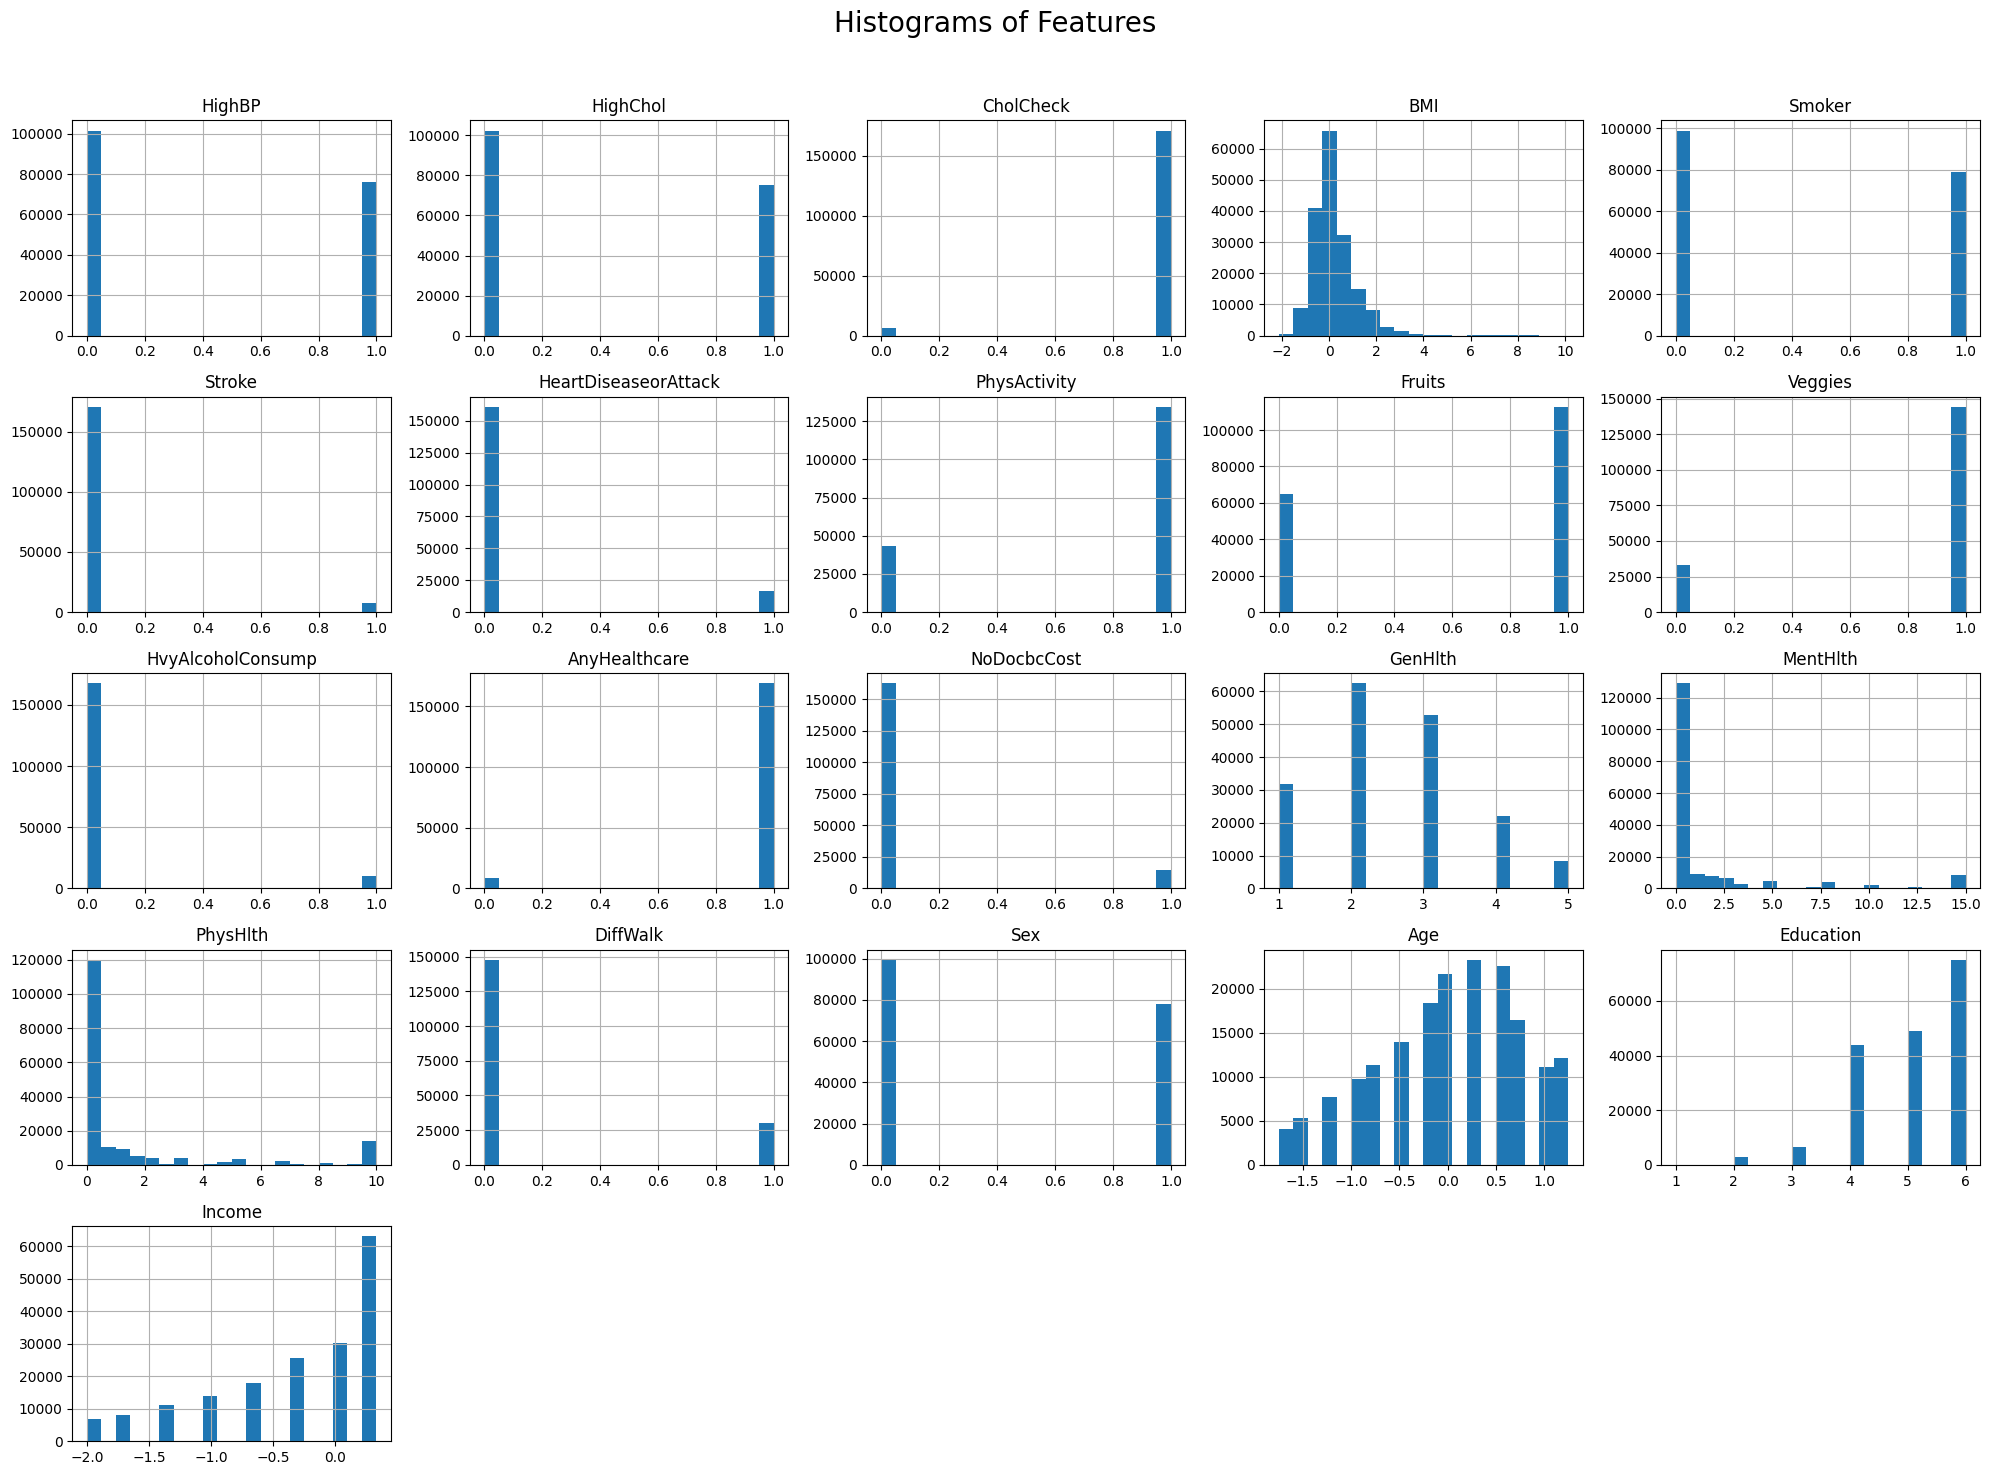

In [12]:
# **Objective 2: In-depth Exploratory Data Analysis (EDA) and Feature Engineering**

print("\n**Objective 2: In-depth Exploratory Data Analysis (EDA) and Feature Engineering**")

# **Univariate Analysis:** Analyze the distribution of individual features
print("\nUnivariate Analysis - Distribution of Features:")
X_train.hist(figsize=(20,15), bins=20)
plt.suptitle('Histograms of Features', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to fit title
plt.show()



Bivariate Analysis - Correlation Matrix:


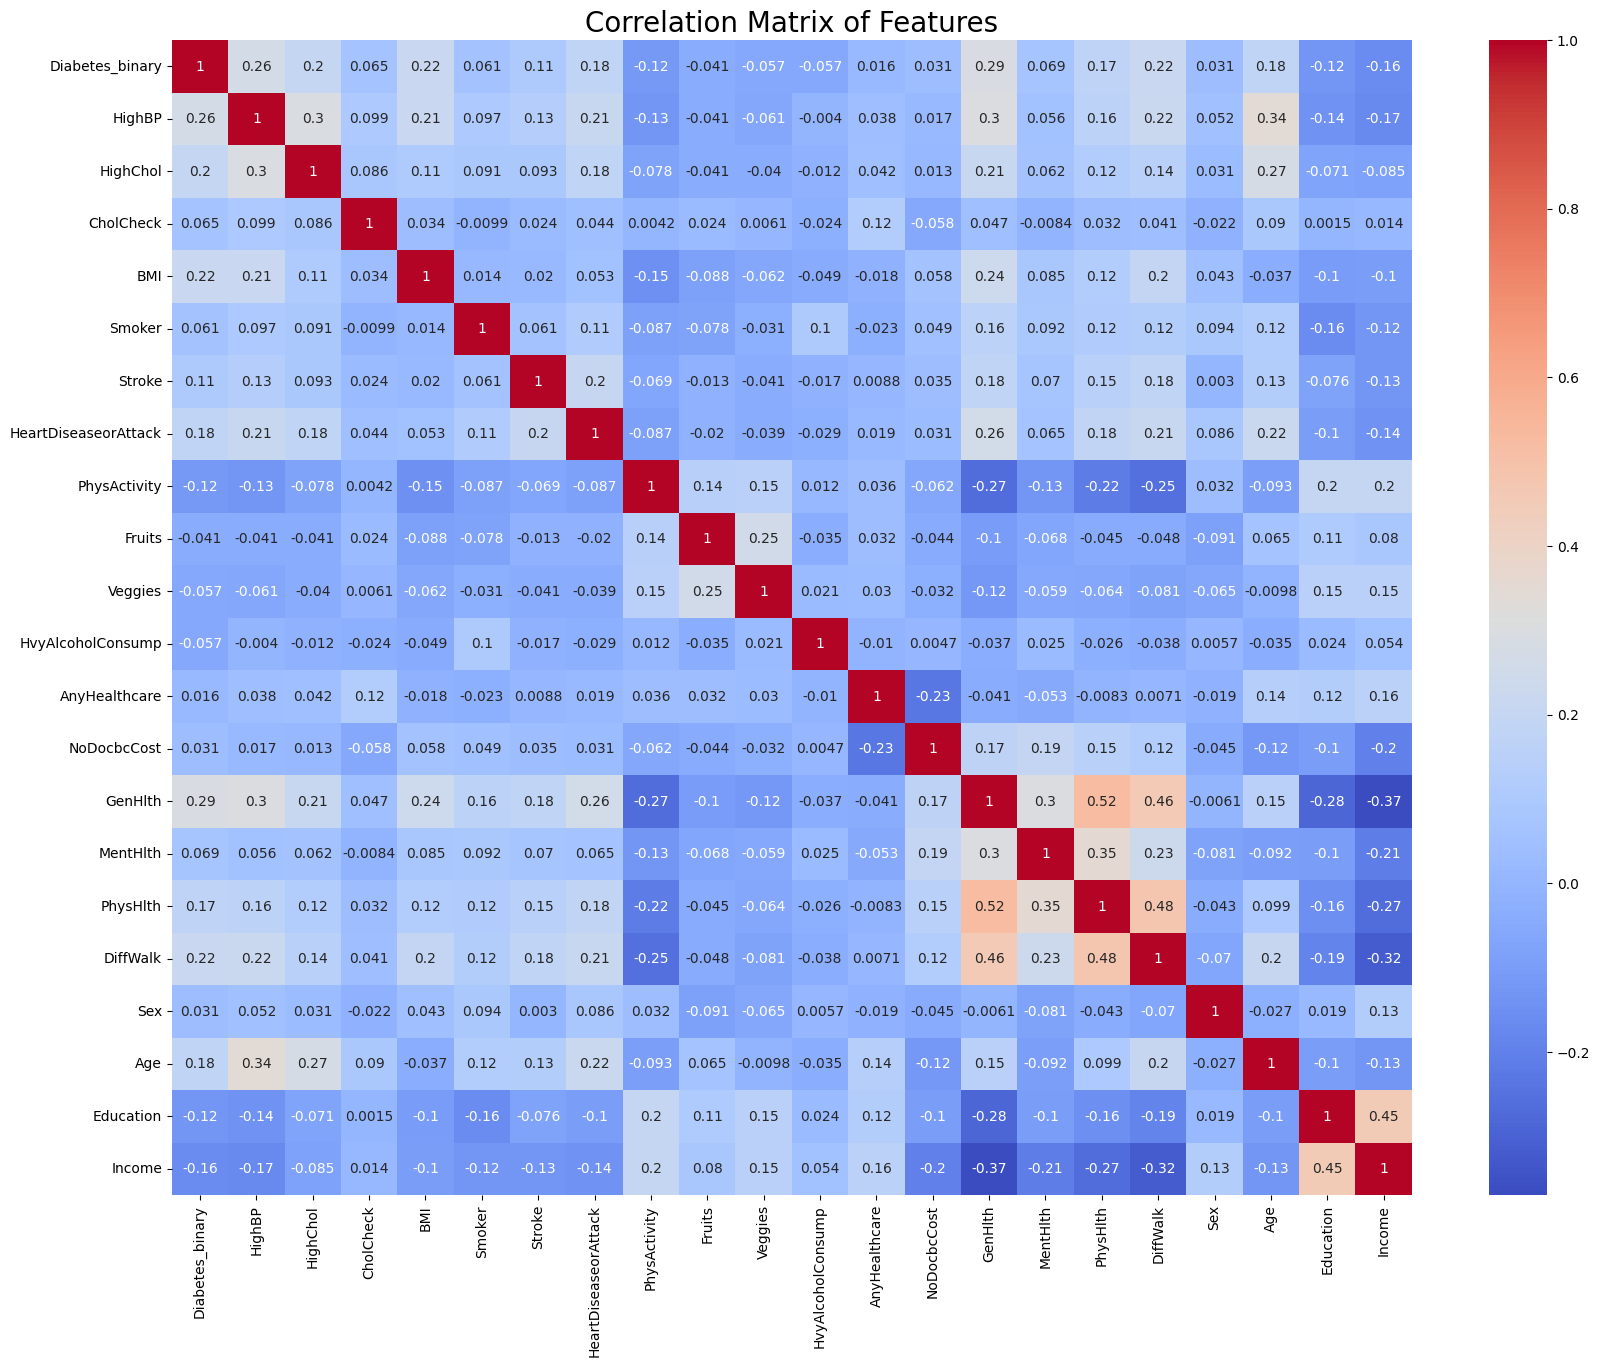

In [13]:
# **Bivariate and Multivariate Analysis:** Explore relationships between features and the target variable
print("\nBivariate Analysis - Correlation Matrix:")
correlation_matrix = data.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features', fontsize=20)
plt.show()


Bivariate Analysis - Enhanced Pair Plots (Optimal Combination - KDE Off-Diagonal, Histograms Diagonal):


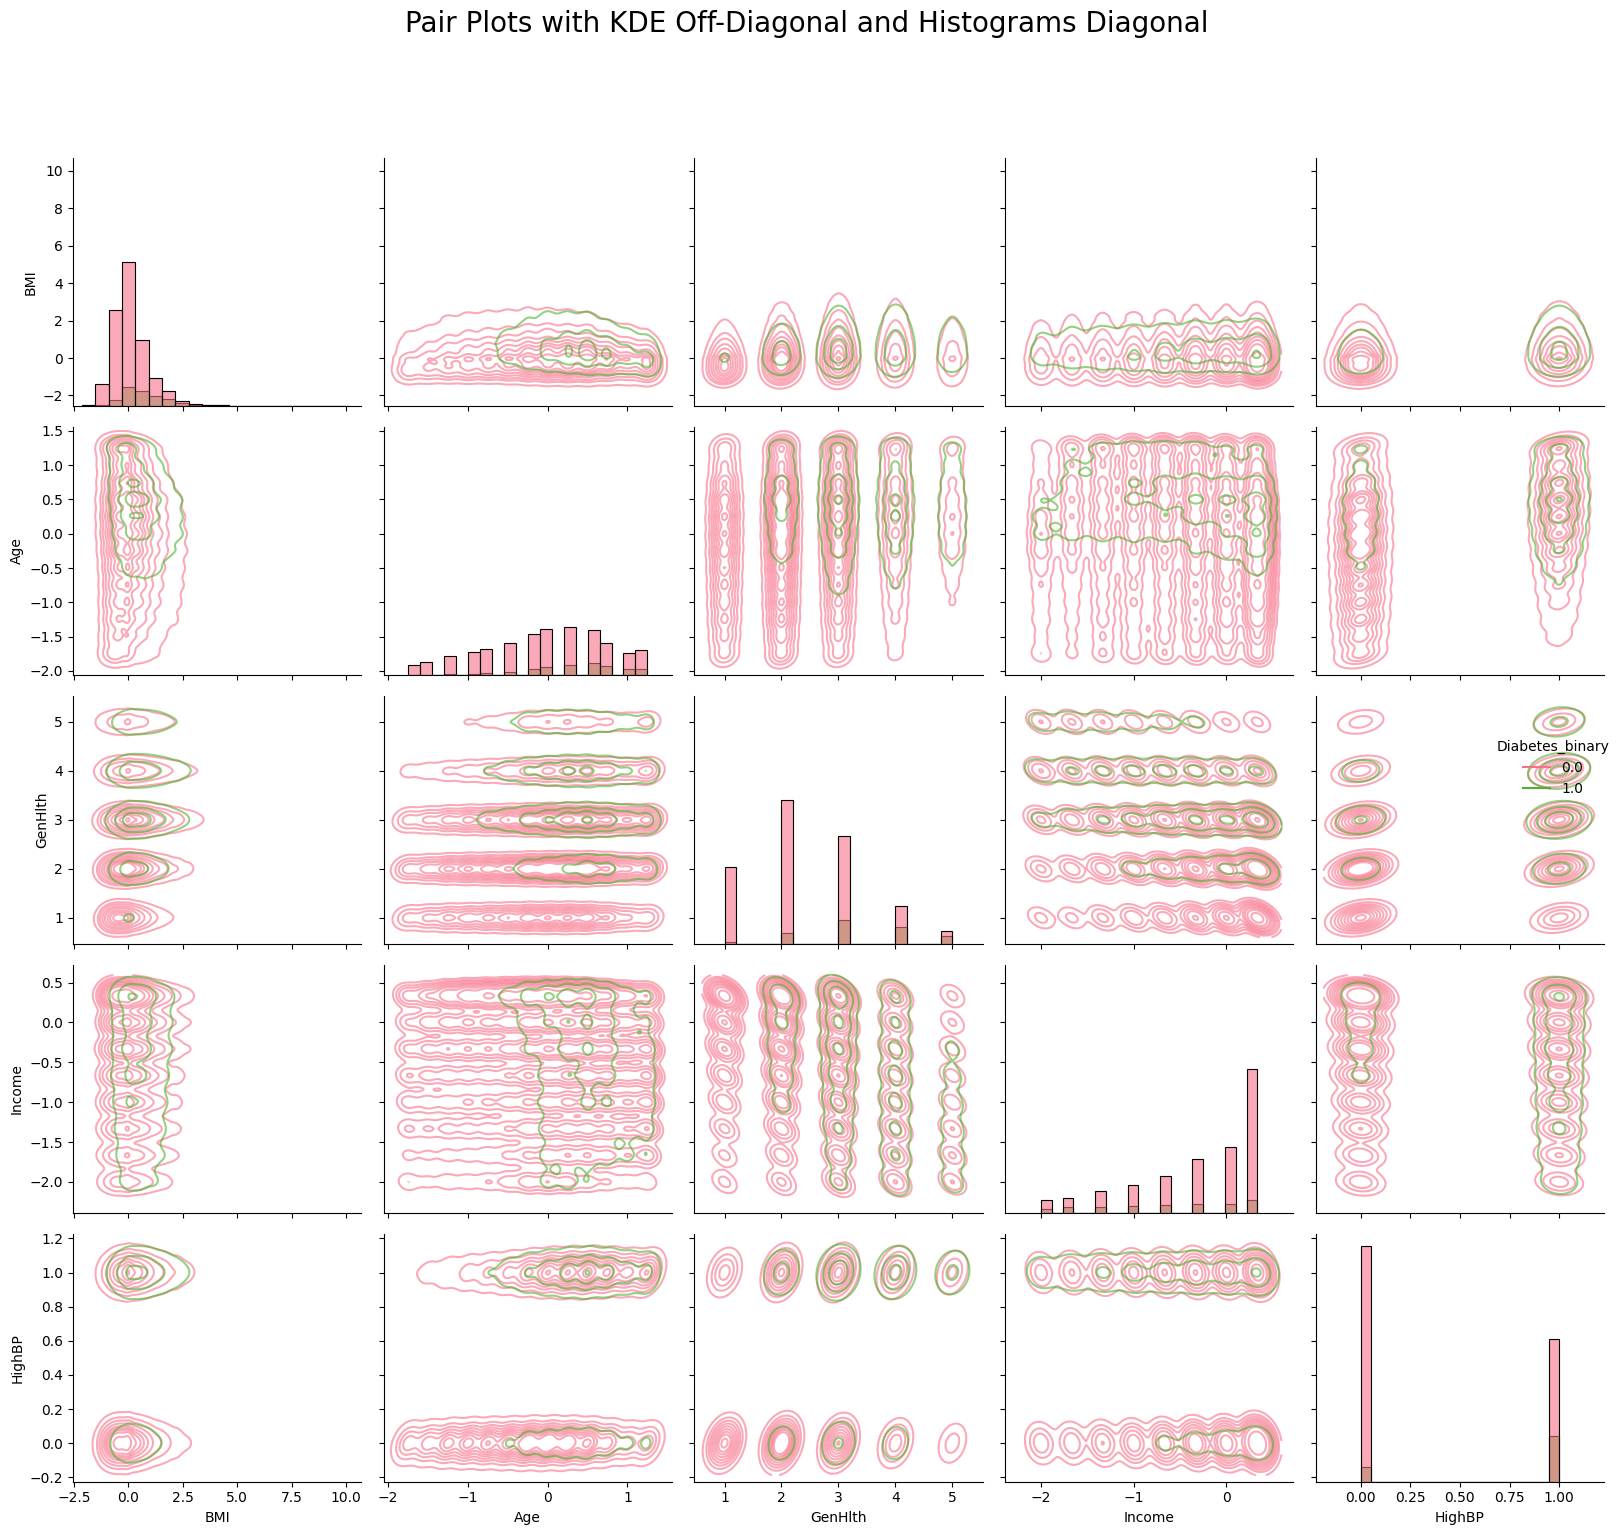

In [14]:
# Pair plots for selected features
print("\nBivariate Analysis - Enhanced Pair Plots (Optimal Combination - KDE Off-Diagonal, Histograms Diagonal):")

features_for_pairplot = ['Diabetes_binary', 'BMI', 'Age', 'GenHlth', 'Income', 'HighBP']

# Define a visually distinct color palette
palette = sns.color_palette("husl", n_colors=3)[:2] # Use only first 2 colors for binary target

pair_plot_grid_kde_hist = sns.pairplot(
    data[features_for_pairplot],
    hue='Diabetes_binary',
    kind='kde', # Use KDE for off-diagonal plots for bivariate distributions
    diag_kind='hist', # Diagonal as histogram for univariate distributions
    palette=palette,
    plot_kws={'alpha': 0.6}, # Customization for KDE plots (transparency)
    diag_kws={'bins': 20, 'fill': True, 'alpha': 0.6, 'color': [palette[0], palette[1]]}, # Customize histograms
    height=3 # Adjust height for readability
)

pair_plot_grid_kde_hist.fig.suptitle("Pair Plots with KDE Off-Diagonal and Histograms Diagonal", fontsize=20, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



Univariate Analysis - Boxplots for Key Features:


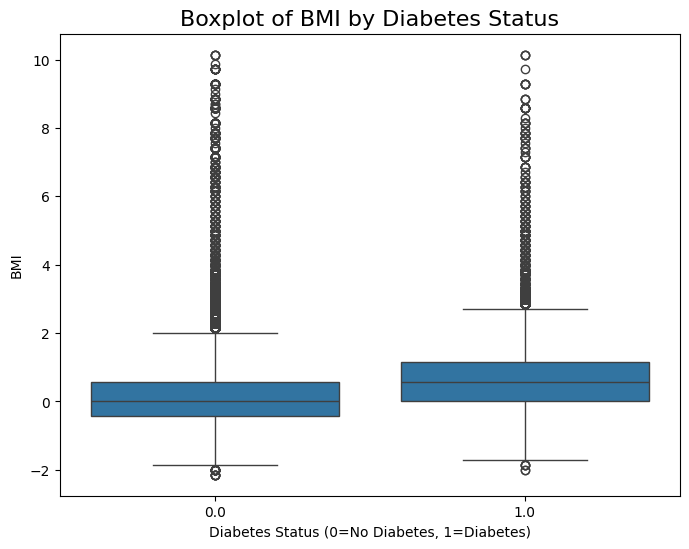

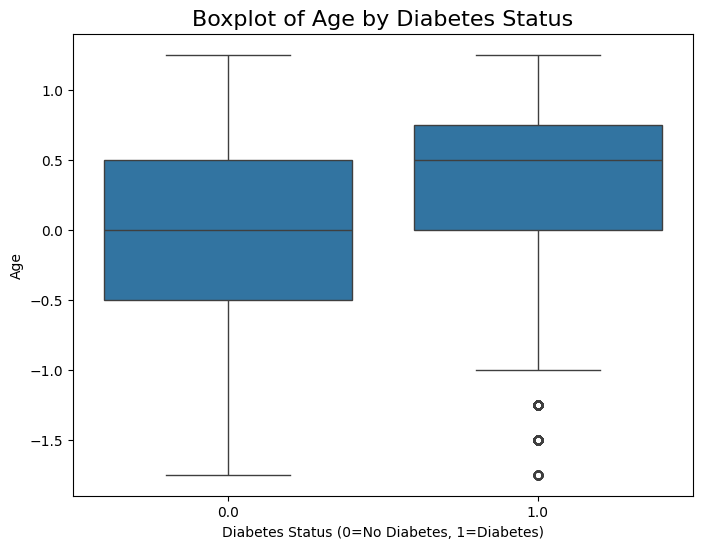

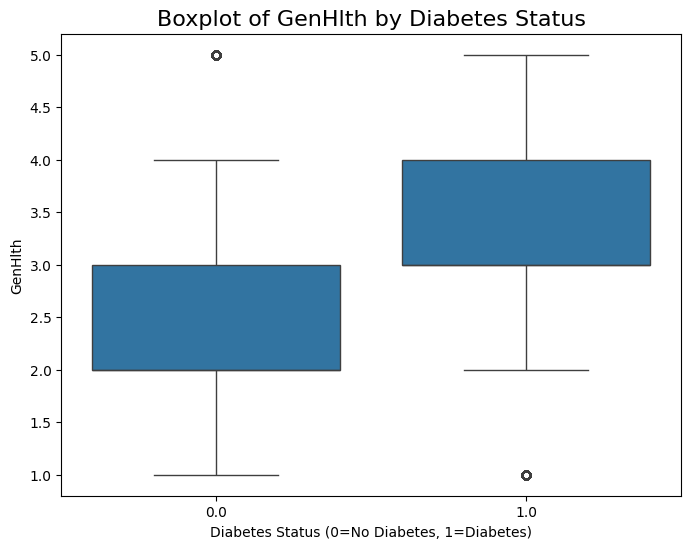

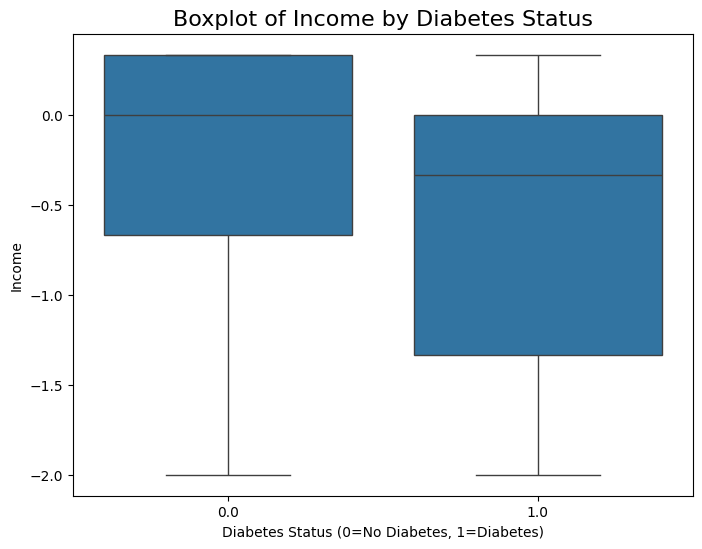

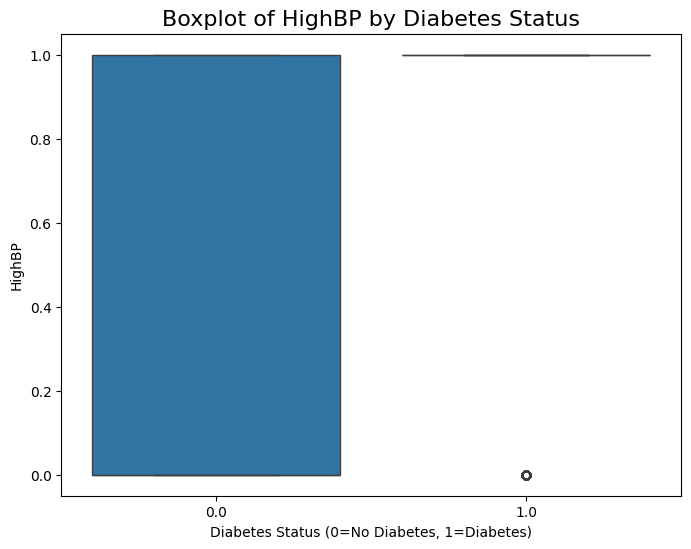


Univariate Analysis - Violin Plots for Key Features:


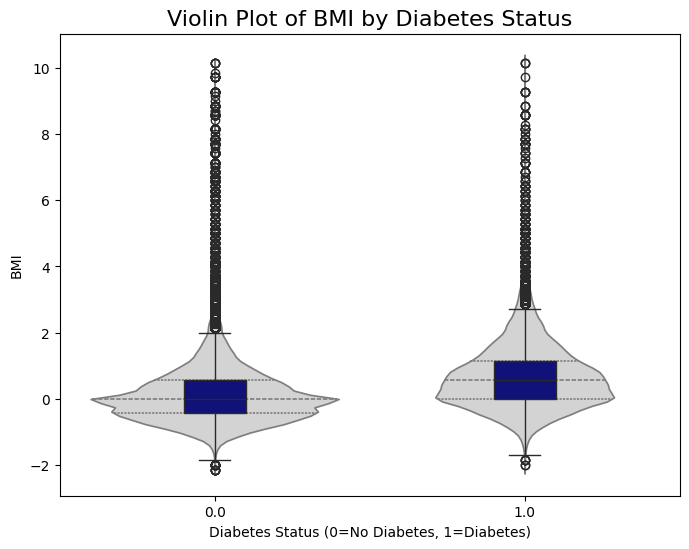

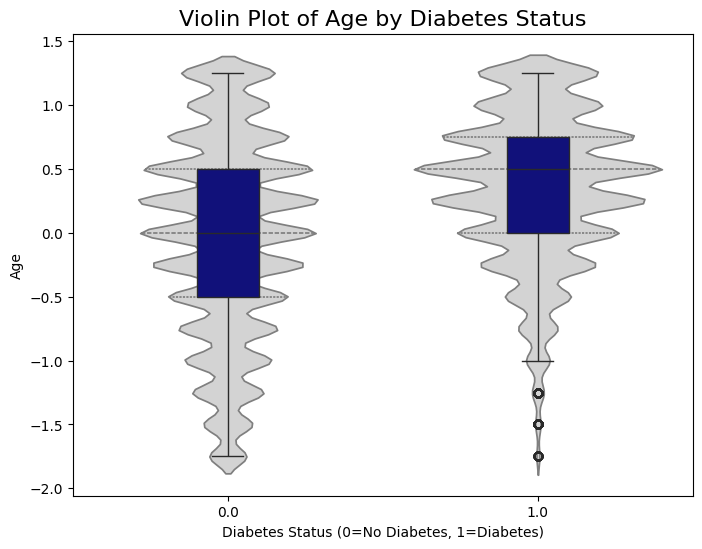

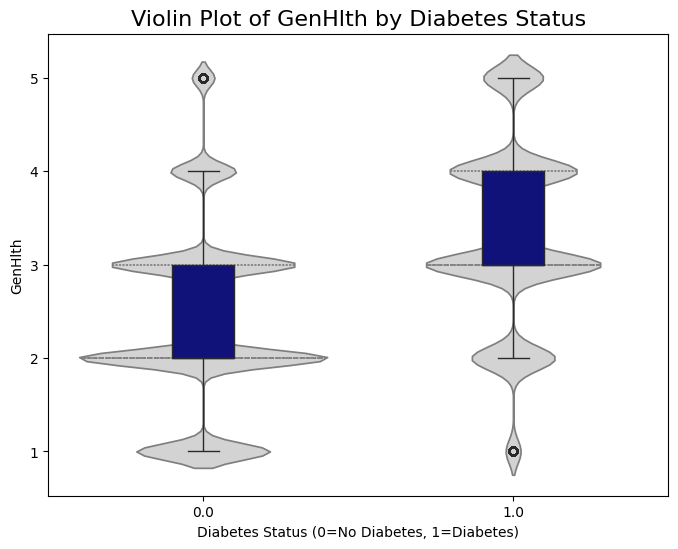

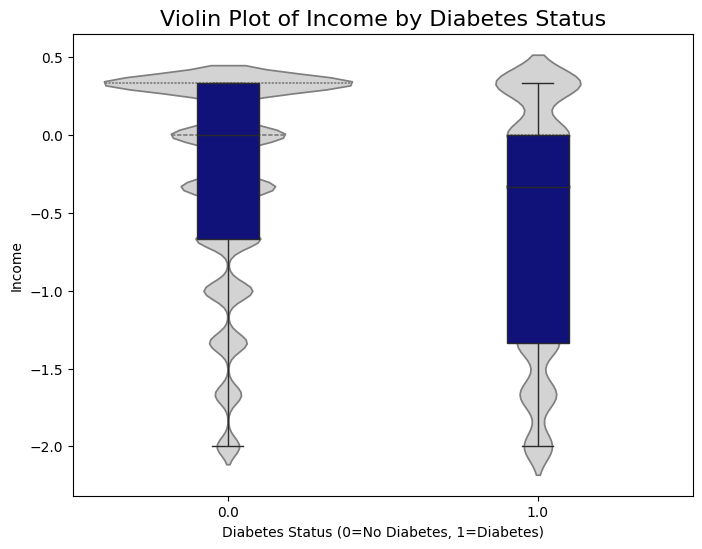

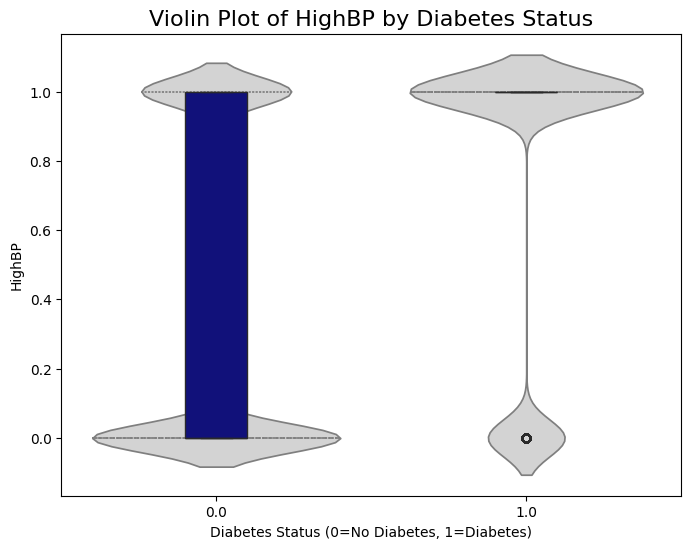

In [15]:
# Univariate Analysis - Boxplots and Violin Plots for Key Features
print("\nUnivariate Analysis - Boxplots for Key Features:")

features_for_boxplots_violin = ['BMI', 'Age', 'GenHlth', 'Income', 'HighBP'] # Key features list (excluding target)

for feature in features_for_boxplots_violin:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Diabetes_binary', y=feature, data=data)
    plt.title(f'Boxplot of {feature} by Diabetes Status', fontsize=16)
    plt.xlabel('Diabetes Status (0=No Diabetes, 1=Diabetes)')
    plt.ylabel(feature)
    plt.show()

print("\nUnivariate Analysis - Violin Plots for Key Features:")

for feature in features_for_boxplots_violin:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='Diabetes_binary', y=feature, data=data, inner="quart", color="lightgray") # Added inner="quart" and color for better visualization
    sns.boxplot(x='Diabetes_binary', y=feature, data=data, width=0.2, color="darkblue") # Overlay boxplot for median and IQR
    plt.title(f'Violin Plot of {feature} by Diabetes Status', fontsize=16)
    plt.xlabel('Diabetes Status (0=No Diabetes, 1=Diabetes)')
    plt.ylabel(feature)
    plt.show()


In [16]:
# **Feature Engineering:** Explore feature engineering techniques to create new, potentially more informative features.
print("\nFeature Engineering - Creating Interaction and Categorical Features based on EDA Insights:")

# 1. BMI Categories Feature:
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Healthy weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

X_train['BMI_Category'] = X_train['BMI'].apply(bmi_category)
X_val['BMI_Category'] = X_val['BMI'].apply(bmi_category)
X_test['BMI_Category'] = X_test['BMI'].apply(bmi_category)
print("Engineered 'BMI_Category' feature.")


# 2. BMI-Age Interaction Feature:
X_train['BMI_Age_Interaction'] = X_train['BMI'] * X_train['Age']
X_val['BMI_Age_Interaction'] = X_val['BMI'] * X_val['Age']
X_test['BMI_Age_Interaction'] = X_test['BMI'] * X_test['Age']
print("Engineered 'BMI_Age_Interaction' feature.")

# 3. GenHlth-HighBP Interaction Feature:
X_train['Health_Risk_Index'] = X_train['GenHlth'] * X_train['HighBP']
X_val['Health_Risk_Index'] = X_val['GenHlth'] * X_val['HighBP']
X_test['Health_Risk_Index'] = X_test['GenHlth'] * X_test['HighBP']
print("Engineered 'Health_Risk_Index' feature.")


# One-Hot Encode Categorical Feature: BMI_Category
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False for dense array output
encoder.fit(X_train[['BMI_Category']]) # Fit encoder on training data categories

# Transform train, validation, and test sets
bmi_cat_train_encoded = encoder.transform(X_train[['BMI_Category']])
bmi_cat_val_encoded = encoder.transform(X_val[['BMI_Category']])
bmi_cat_test_encoded = encoder.transform(X_test[['BMI_Category']])

# Create DataFrames from encoded arrays and set column names
bmi_cat_train_df = pd.DataFrame(bmi_cat_train_encoded, columns=encoder.get_feature_names_out(['BMI_Category']), index=X_train.index)
bmi_cat_val_df = pd.DataFrame(bmi_cat_val_encoded, columns=encoder.get_feature_names_out(['BMI_Category']), index=X_val.index)
bmi_cat_test_df = pd.DataFrame(bmi_cat_test_encoded, columns=encoder.get_feature_names_out(['BMI_Category']), index=X_test.index)

# Concatenate encoded features with original DataFrames (dropping original BMI_Category column)
X_train = pd.concat([X_train.drop('BMI_Category', axis=1), bmi_cat_train_df], axis=1)
X_val = pd.concat([X_val.drop('BMI_Category', axis=1), bmi_cat_val_df], axis=1)
X_test = pd.concat([X_test.drop('BMI_Category', axis=1), bmi_cat_test_df], axis=1)

print("One-hot encoded 'BMI_Category' feature and concatenated to DataFrames.")


print("\n**Objective 2: In-depth Exploratory Data Analysis (EDA) and Feature Engineering - COMPLETED**")


Feature Engineering - Creating Interaction and Categorical Features based on EDA Insights:
Engineered 'BMI_Category' feature.
Engineered 'BMI_Age_Interaction' feature.
Engineered 'Health_Risk_Index' feature.
One-hot encoded 'BMI_Category' feature and concatenated to DataFrames.

**Objective 2: In-depth Exploratory Data Analysis (EDA) and Feature Engineering - COMPLETED**


In [17]:
# --- Feature Selection/Reduction based on Correlation (Illustrative Example - User can customize) ---
print("\nFeature Selection/Reduction - Correlation-based (Illustrative Example):")

correlation_threshold = 0.8 # Example threshold - adjust as needed

# Calculate correlation matrix (already calculated earlier as correlation_matrix)
# Use the correlation matrix calculated earlier: correlation_matrix = data.corr()

# Identify highly correlated features (absolute value of correlation > threshold)
upper_triangle_corr_matrix = correlation_matrix.abs().where(np.triu(np.ones(correlation_matrix.corr().shape), k=1).astype(bool)) # Select upper triangle for redundancy removal
highly_corr_features = [column for column in upper_triangle_corr_matrix.columns if any(upper_triangle_corr_matrix[column] > correlation_threshold)]

print(f"\nFeatures identified for potential removal based on correlation > {correlation_threshold}: {highly_corr_features}")

# Example: Reduce features by dropping highly correlated ones (Illustrative - User can customize)
X_reduced_corr = X_train.drop(highly_corr_features, axis=1, errors='ignore') # errors='ignore' in case some features are already dropped
print(f"Shape of X_train before correlation-based reduction: {X_train.shape}")
print(f"Shape of X_reduced_corr after correlation-based reduction: {X_reduced_corr.shape}")


# --- Calculate VIF for the remaining features AFTER correlation-based reduction ---
print("\n--- Calculating VIF for remaining features ---")

vif_data = pd.DataFrame()
vif_data["feature"] = X_reduced_corr.columns # Use X_reduced_corr columns

# Impute infinite values with a large number (e.g., 1e10) before calculating VIF
X_reduced_corr_fillna = X_reduced_corr.replace([np.inf, -np.inf], 1e10)

# Handle potential NaN values in X_reduced_corr_fillna (impute with mean for VIF calculation)
X_reduced_corr_fillna = X_reduced_corr_fillna.fillna(X_reduced_corr_fillna.mean(numeric_only=True))

vif_data["VIF"] = [variance_inflation_factor(X_reduced_corr_fillna.values, i)
                   for i in range(X_reduced_corr_fillna.shape[1])]  # Use X_reduced_corr_fillna

print(vif_data.sort_values(by=['VIF'], ascending=False))
print("\n--- VIF Interpretation ---")
print("VIF values > 5 or 10 are often considered indicative of high multicollinearity.")
print("Consider further feature reduction or using regularization techniques if multicollinearity is still a concern.")


Feature Selection/Reduction - Correlation-based (Illustrative Example):

Features identified for potential removal based on correlation > 0.8: []
Shape of X_train before correlation-based reduction: (177576, 24)
Shape of X_reduced_corr after correlation-based reduction: (177576, 24)

--- Calculating VIF for remaining features ---
                     feature         VIF
23  BMI_Category_Underweight  100.773872
22         Health_Risk_Index   10.109524
0                     HighBP    7.926670
13                   GenHlth    2.573591
15                  PhysHlth    1.633104
16                  DiffWalk    1.558273
20                    Income    1.503468
18                       Age    1.356778
19                 Education    1.324851
14                  MentHlth    1.236949
6       HeartDiseaseorAttack    1.181825
3                        BMI    1.176287
1                   HighChol    1.172696
7               PhysActivity    1.156974
12               NoDocbcCost    1.144489
11         

In [18]:
# --- Address Multicollinearity - Remove BMI_Category_Underweight ---
X_reduced_corr = X_reduced_corr.drop('BMI_Category_Underweight', axis=1, errors='ignore')
X_val = X_val.drop('BMI_Category_Underweight', axis=1, errors='ignore') # Apply to validation set as well
X_test = X_test.drop('BMI_Category_Underweight', axis=1, errors='ignore') # Apply to test set as well
print("\nRemoved 'BMI_Category_Underweight' feature to reduce multicollinearity.")
print(f"Shape of X_reduced_corr after removing BMI_Category_Underweight: {X_reduced_corr.shape}")


# --- Re-calculate VIF for the remaining features AFTER removing BMI_Category_Underweight ---
print("\n--- Re-calculating VIF for remaining features ---")

vif_data = pd.DataFrame()
vif_data["feature"] = X_reduced_corr.columns # Use X_reduced_corr columns

# Impute infinite values with a large number (e.g., 1e10) before calculating VIF
X_reduced_corr_fillna = X_reduced_corr.replace([np.inf, -np.inf], 1e10)

# Handle potential NaN values in X_reduced_corr_fillna (impute with mean for VIF calculation)
X_reduced_corr_fillna = X_reduced_corr_fillna.fillna(X_reduced_corr_fillna.mean(numeric_only=True))

vif_data["VIF"] = [variance_inflation_factor(X_reduced_corr_fillna.values, i)
                   for i in range(X_reduced_corr_fillna.shape[1])]  # Use X_reduced_corr_fillna

print(vif_data.sort_values(by=['VIF'], ascending=False))
print("\n--- VIF Interpretation (after removing BMI_Category_Underweight) ---")
print("VIF values > 5 or 10 are often considered indicative of high multicollinearity.")
print("Consider further feature reduction or using regularization techniques if multicollinearity is still a concern.")


# --- Note for Model Training (Objective 3 & 4) ---
print("\n--- IMPORTANT NOTE FOR MODEL TRAINING (Objective 3 & 4) ---")
print("Remember to use regularization (L1 or L2) in Logistic Regression and Neural Network models")
print("to mitigate potential multicollinearity from Health_Risk_Index and HighBP.")
print("Tree-based models (Random Forest, Gradient Boosting) are less sensitive to multicollinearity.")


Removed 'BMI_Category_Underweight' feature to reduce multicollinearity.
Shape of X_reduced_corr after removing BMI_Category_Underweight: (177576, 23)

--- Re-calculating VIF for remaining features ---
                 feature        VIF
19             Education  23.836019
2              CholCheck  21.923408
11         AnyHealthcare  19.237762
22     Health_Risk_Index  15.702729
13               GenHlth  14.582949
0                 HighBP  13.458417
9                Veggies   5.774040
7           PhysActivity   4.682411
8                 Fruits   3.028006
1               HighChol   2.033238
15              PhysHlth   2.008133
4                 Smoker   1.934955
17                   Sex   1.888787
16              DiffWalk   1.873403
20                Income   1.656736
14              MentHlth   1.465333
18                   Age   1.340743
6   HeartDiseaseorAttack   1.303959
12           NoDocbcCost   1.238227
3                    BMI   1.227175
5                 Stroke   1.129334
10    

In [19]:
def iterative_vif_reduction(X_df, vif_threshold=10.0):
    """
    Iteratively removes features with the highest VIF until all features have VIF below the threshold.

    Args:
        X_df (pd.DataFrame): DataFrame containing features.
        vif_threshold (float): VIF threshold above which features are removed.

    Returns:
        pd.DataFrame: DataFrame with reduced features (multicollinearity reduced).
        list: List of features removed during the process.
    """

    reduced_X_df = X_df.copy() # Create a copy to avoid modifying original DataFrame
    features_removed = []

    while True:
        vif_data = pd.DataFrame()
        vif_data["feature"] = reduced_X_df.columns

        # Impute infinite values and NaN values for VIF calculation
        X_fillna = reduced_X_df.replace([np.inf, -np.inf], 1e10).fillna(reduced_X_df.mean(numeric_only=True))
        vif_data["VIF"] = [variance_inflation_factor(X_fillna.values, i)
                           for i in range(X_fillna.shape[1])]

        max_vif = vif_data['VIF'].max()
        if max_vif <= vif_threshold:
            break # Stop iteration if no feature exceeds VIF threshold

        feature_to_remove = vif_data.sort_values(by=['VIF'], ascending=False).iloc[0]['feature'] # Feature with highest VIF
        reduced_X_df = reduced_X_df.drop(feature_to_remove, axis=1, errors='ignore')
        features_removed.append(feature_to_remove)
        print(f"Removed feature: {feature_to_remove}, Max VIF: {max_vif:.2f}") # Print removed feature and max VIF

    print("\n--- Iterative VIF Reduction Complete ---")
    print("Remaining features (multicollinearity reduced):")
    print(reduced_X_df.columns.tolist())
    print("\nFeatures removed during VIF reduction:")
    print(features_removed)

    vif_data_final = pd.DataFrame()  # Calculate and print final VIFs for remaining features
    vif_data_final["feature"] = reduced_X_df.columns
    X_fillna_final = reduced_X_df.replace([np.inf, -np.inf], 1e10).fillna(reduced_X_df.mean(numeric_only=True))
    vif_data_final["VIF"] = [variance_inflation_factor(X_fillna_final.values, i)
                           for i in range(X_fillna_final.shape[1])]
    print("\nFinal VIF values for remaining features:")
    print(vif_data_final.sort_values(by=['VIF'], ascending=False))


    return reduced_X_df, features_removed

# Apply iterative VIF reduction (using X_reduced_corr from previous step as starting point)
X_reduced_vif, removed_features_vif = iterative_vif_reduction(X_reduced_corr, vif_threshold=10.0) # You can adjust vif_threshold

# Apply the same reduction to validation and test sets for consistency
X_val_reduced_vif = X_val[X_reduced_vif.columns]
X_test_reduced_vif = X_test[X_reduced_vif.columns]


# Print shapes to confirm reduction
print(f"\nShape of X_reduced_corr before Iterative VIF Reduction: {X_reduced_corr.shape}")
print(f"Shape of X_reduced_vif after Iterative VIF Reduction: {X_reduced_vif.shape}")

Removed feature: Education, Max VIF: 23.84
Removed feature: CholCheck, Max VIF: 19.13
Removed feature: Health_Risk_Index, Max VIF: 14.92
Removed feature: AnyHealthcare, Max VIF: 10.73

--- Iterative VIF Reduction Complete ---
Remaining features (multicollinearity reduced):
['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Income', 'BMI_Age_Interaction']

Features removed during VIF reduction:
['Education', 'CholCheck', 'Health_Risk_Index', 'AnyHealthcare']

Final VIF values for remaining features:
                 feature       VIF
11               GenHlth  7.625138
8                Veggies  4.831441
6           PhysActivity  3.821185
7                 Fruits  2.890759
0                 HighBP  2.313780
1               HighChol  2.005177
13              PhysHlth  1.969501
3                 Smoker  1.909258
14              DiffWal

In [ ]:
# Objective 3: Development and Training of Diverse Machine Learning Models
print("\n**Objective 3: Development and Training of Diverse Machine Learning")
print("Models (using VIF-reduced data) - THOROUGH GridSearchCV &")
print("Expanded LR Tuning, Efficient RF Tuning, GB Tuning**")  # Updated description

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', penalty='l2'), # Added regularization for LR
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),  #  Keep original, we'll tune it.
    'Neural Network': MLPClassifier(random_state=42, max_iter=300, early_stopping=True, hidden_layer_sizes=(100,), alpha=0.0001) # Simple NN for demonstration
}
trained_models = {}

# Use X_reduced_vif, X_val_reduced_vif, X_test_reduced_vif for training and validation/testing
X_train_vif = X_reduced_vif # Assign VIF-reduced training data - use X_reduced_vif
X_val_vif = X_val_reduced_vif
X_test_vif = X_test_reduced_vif

# --- Thorough Optimization for Logistic Regression using GridSearchCV - EXPANDED GRID ---
print("\n--- Thoroughly Optimizing Logistic Regression Model using GridSearchCV - EXPANDED GRID ---")

param_grid_lr = { # Define EXPANDED hyperparameter grid for Logistic Regression - EVEN MORE THOROUGH
    'C': np.logspace(-6, 6, 50), # Even wider and finer C range (50 values)
    'penalty': ['l1', 'l2'], # Explore both L1 and L2 penalties
    'solver': ['liblinear', 'saga'] # ADDED: Explore both 'liblinear' and 'saga' solvers - for L2 penalty, 'saga' can be more efficient
}
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000), # Base Logistic Regression model (solver will be set by param_grid)
    param_grid=param_grid_lr, # Expanded hyperparameter grid
    scoring='f1_weighted', # Metric to optimize (weighted F1-score)
    cv=10, # Increased cross-validation folds to 10 (more robust evaluation)
    verbose=2, # Verbosity level
    n_jobs=-1 # Parallel processing
)
grid_search_lr.fit(X_train_vif, y_train) # Fit GridSearchCV on VIF-reduced training data

best_lr_model = grid_search_lr.best_estimator_ # Get the best Logistic Regression model from GridSearchCV
best_lr_params = grid_search_lr.best_params_ # Get the best hyperparameters found by GridSearchCV
best_lr_score = grid_search_lr.best_score_ # Get the best validation score (mean cross-validated F1-score)

print("\n--- GridSearchCV Results for Logistic Regression (Thorough Search - Expanded Grid) ---")
print(f"Best Parameters (Logistic Regression): {best_lr_params}")
print(f"Best Validation F1-Score (Logistic Regression): {best_lr_score:.4f}")

# Update trained_models dictionary with the tuned Logistic Regression model
trained_models['Logistic Regression'] = best_lr_model # Replace default LR with tuned LR


# --- Efficient Optimization for Random Forest using RandomizedSearchCV ---
print("\n--- Efficiently Optimizing Random Forest Model using RandomizedSearchCV ---")
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500], # Fewer, strategically chosen values
    'max_depth': [None, 10, 20, 30],  # Include None and a few specific depths
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False], # Include both options
    'max_features': ['sqrt', 'log2', None] # Include sqrt, log2, and None.
}

# Use RandomizedSearchCV for efficient search.  Crucially: n_iter controls the number of combinations tried.
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid_rf,
    scoring='f1_weighted',
    cv=5, # Fewer CV folds for Random Forest (it's more robust)
    verbose=2,
    n_jobs=-1,
    n_iter=20, # Try 20 parameter combinations.  This is KEY for efficiency.
    random_state=42 # Added random_state for reproducibility
)
random_search_rf.fit(X_train_vif, y_train)

best_rf_model = random_search_rf.best_estimator_
best_rf_params = random_search_rf.best_params_
best_rf_score = random_search_rf.best_score_

print("\n--- RandomizedSearchCV Results for Random Forest (Efficient Search) ---")
print(f"Best Parameters (Random Forest): {best_rf_params}")
print(f"Best Validation F1-Score (Random Forest): {best_rf_score:.4f}")

# Update trained_models dictionary with the tuned Random Forest model
trained_models['Random Forest'] = best_rf_model # Replace default RF with tuned RF


# --- Efficient Optimization for Gradient Boosting using GridSearchCV with Early Stopping ---
print("\n--- Efficiently Optimizing Gradient Boosting Model using GridSearchCV with Early Stopping ---")

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],  # Add subsample
    'max_features': [0.8, 1.0] # Add max_features
}


#Crucially, we add n_iter_no_change and tol for early stopping
grid_search_gb = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42,  n_iter_no_change=5, tol=0.001),  # Use early stopping
    param_grid=param_grid_gb,
    scoring='f1_weighted',
    cv=5,
    verbose=2,
    n_jobs=-1
)


grid_search_gb.fit(X_train_vif, y_train)

best_gb_model = grid_search_gb.best_estimator_
best_gb_params = grid_search_gb.best_params_
best_gb_score = grid_search_gb.best_score_

print("\n--- GridSearchCV Results for Gradient Boosting (Efficient Search with Early Stopping) ---")
print(f"Best Parameters (Gradient Boosting): {best_gb_params}")
print(f"Best Validation F1-Score (Gradient Boosting): {best_gb_score:.4f}")

# Update trained_models dictionary with the tuned Gradient Boosting model
trained_models['Gradient Boosting'] = best_gb_model
# --- Training other models (Decision Tree, Neural Network) ---
for name, model in models.items():
    if name in ['Logistic Regression', 'Random Forest', 'Gradient Boosting']:
        # Skip - already trained and tuned above
        continue
    print(f"\nTraining {name} with VIF-reduced data...")
    model.fit(X_train_vif, y_train)  # Use X_train_vif
    trained_models[name] = model
    print(f"{name} trained.")

print("\n**Objective 3: Development and Training of Diverse Machine")
print("Learning Models - COMPLETED (using VIF-reduced data)**")


**Objective 3: Development and Training of Diverse Machine Learning
Models (using VIF-reduced data) - THOROUGH GridSearchCV &
Expanded LR Tuning, Efficient RF Tuning, GB Tuning**

--- Thoroughly Optimizing Logistic Regression Model using GridSearchCV - EXPANDED GRID ---
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

--- GridSearchCV Results for Logistic Regression (Thorough Search - Expanded Grid) ---
Best Parameters (Logistic Regression): {'C': np.float64(0.7543120063354607), 'penalty': 'l1', 'solver': 'saga'}
Best Validation F1-Score (Logistic Regression): 0.8300

--- Efficiently Optimizing Random Forest Model using RandomizedSearchCV ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# --- Neural Network Optimization (Keras Tuner) - SEPARATE BLOCK ---

print("\n--- Efficiently Optimizing Neural Network Model using Keras Tuner ---")

# --- Prepare Data specifically for the Neural Network ---
# Get number of classes from the original y_train (assuming it's available from Obj 1/2)
num_classes = len(np.unique(y_train))

# One-hot encode target variables *specifically* for the Neural Network
# Make sure y_train, y_val, y_test here refer to the original 1D labels
y_train_nn = to_categorical(y_train, num_classes=num_classes)
y_val_nn = to_categorical(y_val, num_classes=num_classes)
y_test_nn = to_categorical(y_test, num_classes=num_classes) # also for evaluation later

# --- Define the model-building function for Keras Tuner ---
def build_nn_model(hp):
    """Builds a Keras Sequential model with tunable hyperparameters."""
    model = Sequential()
    # Input Layer
    model.add(Dense(
        hp.Int('units_1', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=l2(0.01),
        input_shape=(X_train_vif.shape[1],)  # Ensure X_train_vif is defined from VIF reduction steps
    ))
    # Hidden Layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            hp.Int(f'units_{i+2}', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ))
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.2, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))  # num_classes for multi-class

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='categorical_crossentropy',  # Correct loss for multi-class
        metrics=['accuracy']
    )
    return model

# --- Keras Tuner Setup and Search ---
tuner = kt.RandomSearch(
    build_nn_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='nn_tuning',
    project_name='diabetes_nn_tuned_isolated', # Use a distinct name
    overwrite=True
)

# Perform hyperparameter search. Use one-hot encoded y_train_nn and y_val_nn.
tuner.search(X_train_vif, y_train_nn, epochs=20, validation_data=(X_val_vif, y_val_nn),
             callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

# --- Get Best Model and Hyperparameters ---
best_nn_hps = tuner.get_best_hyperparameters()[0]
# Retrieve the best model directly from the tuner
best_nn_model_tuned = tuner.get_best_models(num_models=1)[0] # Use a different variable name initially

print("\n--- Keras Tuner Results for Neural Network (Efficient Search) ---")
print(f"Best Hyperparameters (Neural Network): {best_nn_hps.values}")

# --- Retrain the Best NN Model on Combined Training and Validation Data ---
print("\n--- Retraining Best Neural Network Model on Combined Train+Val Data ---")
# Combine training and validation data for retraining
X_train_val_vif = np.concatenate((X_train_vif, X_val_vif), axis=0)
# Combine the *one-hot encoded* y training and validation data
y_train_val_nn = np.concatenate((y_train_nn, y_val_nn), axis=0)

# Rebuild the model *using the best hyperparameters* before fitting on combined data
# Note: Rebuilding ensures a fresh model state if needed, though tuner.get_best_models should return a trained one.
# If tuner returns a trained model, this rebuild might be redundant but is safer.
best_nn_model_final = build_nn_model(best_nn_hps) # Use a distinct name for the final model

# Fit the rebuilt best model on the combined data
best_nn_model_final.fit(X_train_val_vif, y_train_val_nn, epochs=20, batch_size=32,
                        callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)],
                        verbose=0) # Set verbose=0 to avoid excessive output during final training

print("Best Neural Network Model Retrained.")

# --- Evaluate the Final Best NN Model ---
print("\n--- Evaluating Retrained Best Neural Network Model ---")
y_pred_nn = best_nn_model_final.predict(X_test_vif)          # Get probabilities from the final model
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)     # Convert to class labels
y_test_classes = np.argmax(y_test_nn, axis=1)       # Convert one-hot y_test to labels

report_nn = classification_report(y_test_classes, y_pred_nn_classes, output_dict=True)
nn_f1_weighted = report_nn['weighted avg']['f1-score'] # Get weighted F1
print(f"Final Test F1-Score (Neural Network): {nn_f1_weighted:.4f}")

# --- Add the FINAL Retrained Model to the Dictionary ---
# Make sure 'trained_models' dictionary exists from the previous block
trained_models['Neural Network'] = best_nn_model_final # Add the *final*, retrained model

print("\nTuned and Retrained Neural Network added to trained_models.")

In [ ]:
# **Objective 4: Comprehensive Model Evaluation and Comparative Analysis**

print("\n**Objective 4: Comprehensive Model Evaluation and Comparative Analysis (using VIF-reduced data)**")

# --- Ensure the ground truth labels are available in the correct (1D binary) format ---
# Assuming y_test from the initial data split (Objective 1) is still the 1D array (0s and 1s)
y_test_orig = y_test.copy()
# Add a check to be sure
print(f"Unique values in y_test_orig: {np.unique(y_test_orig)}")
if not np.all(np.isin(np.unique(y_test_orig), [0, 1])):
    print("Warning: y_test_orig does not seem to contain only binary labels (0, 1). AUC calculation might be incorrect.")


evaluation_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']
model_performance = {}

# Ensure trained_models dictionary is populated from previous steps
if not trained_models:
    print("Warning: trained_models dictionary is empty. Cannot evaluate models.")
else:
    for name, model in trained_models.items():
        print(f"\nEvaluating {name} with VIF-reduced data...")

        # --- Prediction Handling (Differs for Keras vs Scikit-learn) ---
        if name == 'Neural Network' and isinstance(model, Sequential): # Check if it's the Keras model
            # Keras model prediction (outputs probabilities for all classes due to softmax)
            y_pred_proba_all_classes_nn = model.predict(X_test_vif) # Shape: (n_samples, num_classes)
            y_pred = np.argmax(y_pred_proba_all_classes_nn, axis=1) # Convert probabilities to class labels (0, 1, or 2 - but we evaluate against 0/1)
            # For BINARY AUC, extract probability of the POSITIVE class (index 1)
            if y_pred_proba_all_classes_nn.shape[1] > 1:
                 y_pred_proba_positive = y_pred_proba_all_classes_nn[:, 1]
            else: # Should not happen with softmax > 1 class, but safe fallback
                 y_pred_proba_positive = y_pred_proba_all_classes_nn.flatten()
                 print(f"Warning: Keras model output has unexpected shape for {name}. Assuming binary sigmoid output.")

        elif hasattr(model, 'predict_proba'): # Check if it's a Scikit-learn model with predict_proba
            # Scikit-learn model prediction
            y_pred = model.predict(X_test_vif) # Gives class labels (0, 1, or 2)
            # For BINARY AUC, get probability of the POSITIVE class (class 1)
            y_pred_proba_positive = model.predict_proba(X_test_vif)[:, 1] # Shape: (n_samples,)
        else:
             print(f"Warning: Model '{name}' does not have standard predict or predict_proba methods. Skipping evaluation.")
             continue # Skip to the next model

        # --- Metric Calculation (Use original y_test_orig - the 1D binary labels) ---
        accuracy = accuracy_score(y_test_orig, y_pred)
        # Use weighted average for precision, recall, f1 (handles potential multi-class preds vs binary truth)
        try:
            # Ensure labels includes all possible predicted classes if different from truth
            labels_present = np.union1d(np.unique(y_test_orig), np.unique(y_pred))
            report = classification_report(y_test_orig, y_pred, output_dict=True, zero_division=0, labels=labels_present)
            precision_weighted = report['weighted avg']['precision']
            recall_weighted = report['weighted avg']['recall']
            f1_weighted = report['weighted avg']['f1-score']
        except ValueError as e:
             print(f"Warning: Could not generate classification report for {name}: {e}. Check predictions.")
             precision_weighted, recall_weighted, f1_weighted = 0, 0, 0 # Default values

        # Calculate BINARY AUC-ROC using the probability of the positive class
        try:
            # Ensure y_test_orig is truly binary for standard AUC calculation
            if not np.all(np.isin(np.unique(y_test_orig), [0, 1])):
                 raise ValueError("y_test_orig is not binary. Cannot calculate standard binary AUC.")
            auc_roc = roc_auc_score(y_test_orig, y_pred_proba_positive)
        except ValueError as e:
            print(f"Error calculating binary AUC for {name}: {e}")
            auc_roc = np.nan # Assign NaN on error
        except Exception as e: # Catch other potential errors
            print(f"Unexpected error calculating AUC for {name}: {e}")
            auc_roc = np.nan

        # --- Store Performance ---
        performance = {
            'Accuracy': accuracy,
            'Precision': precision_weighted,
            'Recall': recall_weighted,
            'F1-score': f1_weighted,
            'AUC-ROC': auc_roc
        }
        model_performance[name] = performance
        print(f"{name} Evaluation Metrics (VIF-reduced data): {performance}")

# --- Comparative Analysis - Tabular and Visual ---
if model_performance: # Only proceed if performance data exists
    performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
    print("\nComparative Model Performance (VIF-reduced data):")
    print(performance_df)

    # Plotting
    performance_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Model Performance Comparison (VIF-reduced data)', fontsize=20)
    plt.ylabel('Metric Value')
    plt.xlabel('Models')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Evaluation Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo model performance data to display.")


print("\n**Objective 4: Comprehensive Model Evaluation and Comparative Analysis - COMPLETED (using VIF-reduced data)**")

In [ ]:
# --- Odds Ratios for Logistic Regression Coefficients ---
print("\n--- Odds Ratios for Logistic Regression Coefficients ---")

# Extract coefficients and feature names from the *tuned* Logistic Regression model - use best_lr_model
lr_model_tuned = trained_models['Logistic Regression'] # Get the tuned LR model again (for clarity)
coefficients = lr_model_tuned.coef_[0] # Extract coefficients from the TUNED model
feature_names = X_reduced_vif.columns # Get feature names from VIF-reduced data - use X_reduced_vif columns

odds_ratios_lr = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
odds_ratios_lr['Odds_Ratio'] = np.exp(odds_ratios_lr['Coefficient']) # Exponentiate coefficients to get odds ratios
odds_ratios_lr = odds_ratios_lr.sort_values('Odds_Ratio', ascending=False)

print("\nOdds Ratios from Logistic Regression (Tuned Model):")
display(odds_ratios_lr[['Feature', 'Coefficient', 'Odds_Ratio']])

print("\n--- Interpretation of Odds Ratios ---")
print("Odds Ratios quantify the change in the ODDS of having diabetes for a one-unit increase in the feature,")
print("holding all other features constant.")
print("Odds Ratio > 1: Feature increase -> increased odds of diabetes.")
print("Odds Ratio < 1: Feature increase -> decreased odds of diabetes.")
print("Odds Ratio = 1: Feature has no linear effect on the odds.")
print("Larger Odds Ratio (further from 1, in either direction) -> stronger influence on diabetes odds.")

In [ ]:
# Objective 5: Actionable Insights and Data-Driven Recommendations

# --- Feature Importance for Logistic Regression (Keep Original - Assuming it worked) ---

print("\n**Objective 5: Actionable Insights and Data-Driven Recommendations**")
print("\n--- Analyzing Feature Importance for Logistic Regression ---")

if 'Logistic Regression' in trained_models:
    lr_model = trained_models['Logistic Regression']

    # --- Determine feature names (assuming VIF reduction was done) ---
    if 'X_train_vif' in locals() and hasattr(X_train_vif, 'columns'):
        feature_names = X_train_vif.columns
    elif 'X_reduced_corr' in locals() and hasattr(X_reduced_corr, 'columns'):
        feature_names = X_reduced_corr.columns # Fallback
    elif 'X_train' in locals() and hasattr(X_train, 'columns'):
        feature_names = X_train.columns # Fallback to original
    else:
        print("\nWarning: Could not determine feature names. Cannot calculate importance.")
        feature_names = None

    if feature_names is not None:
        # --- Calculate and Display Logistic Regression Coefficients ---
        try:
            if hasattr(lr_model, 'coef_'):
                coefficients = lr_model.coef_[0]
                feature_importance_lr = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
                feature_importance_lr['Abs_Coefficient'] = feature_importance_lr['Coefficient'].abs()
                feature_importance_lr = feature_importance_lr.sort_values('Abs_Coefficient', ascending=False)

                print("\nFeature Importance from Logistic Regression (Coefficients):")
                display(feature_importance_lr[['Feature', 'Coefficient', 'Abs_Coefficient']])
                print("\n--- Interpretation of Logistic Regression Coefficients ---")
                print("Coefficients represent the linear influence on the log-odds of the positive class.")
                print("Larger absolute values indicate stronger influence.")
                print("Positive: Feature increase -> higher log-odds (higher diabetes likelihood).")
                print("Negative: Feature increase -> lower log-odds (lower diabetes likelihood).")

                # --- Bar Plot for Logistic Regression ---
                plt.figure(figsize=(10, 8))
                num_features_to_plot = min(15, len(feature_importance_lr))
                top_features_lr = feature_importance_lr.head(num_features_to_plot)
                sns.barplot(x=top_features_lr['Abs_Coefficient'], y=top_features_lr['Feature'], color="#34708C")
                plt.title('Feature Importance - Logistic Regression (Absolute Coefficients)', fontsize=18)
                plt.xlabel('Absolute Coefficient Value')
                plt.ylabel('Features')
                plt.tight_layout()
                plt.show()

                # --- Top Features Interpretation (LR) ---
                print("\n--- Interpretation (Top Features - Logistic Regression) ---")
                top_n = min(19, len(feature_importance_lr))
                for index, row in feature_importance_lr.head(top_n).iterrows():
                    direction = "increase" if row['Coefficient'] > 0 else "decrease"
                    print(f"- {row['Feature']}: Coefficient = {row['Coefficient']:.4f}, Influence: {direction} in likelihood.")
            else:
                print("\nLogistic Regression model does not have 'coef_' attribute.")

        except Exception as e:
            print(f"\nError processing Logistic Regression importance: {e}")
    else:
        print("\nSkipping Logistic Regression importance calculation (feature names missing).")
else:
    print("\nWarning: Logistic Regression model not found in trained_models.")


# --- Feature Importance for Neural Network (Manual Permutation Importance) ---
print("\n--- Analyzing Feature Importance for Neural Network (Manual Permutation) ---")

if 'Neural Network' in trained_models:
    nn_model_keras = trained_models['Neural Network'] # The actual Keras Sequential model

    # --- Reuse feature names if determined earlier ---
    if feature_names is not None:
        print("Calculating Manual Permutation Importance for Neural Network (may take a few moments)...")
        try:
            # Ensure necessary data exists
            if 'X_test_vif' not in locals() or 'y_test_orig' not in locals():
                 raise NameError("Required data (X_test_vif or y_test_orig) not found for Manual Permutation Importance.")

            # Ensure y_test_orig is 1D
            if y_test_orig.ndim != 1:
                raise ValueError("y_test_orig must be a 1D array for scoring.")

            n_repeats = 5 # Number of shuffles per feature
            baseline_predictions = nn_model_keras.predict(X_test_vif)
            baseline_pred_classes = np.argmax(baseline_predictions, axis=1)
            baseline_score = f1_score(y_test_orig, baseline_pred_classes, average='weighted', zero_division=0)
            print(f"Baseline F1 Score: {baseline_score:.4f}")

            importances = []
            all_permuted_scores = [] # To calculate standard deviation

            # Get the actual NumPy array for features for efficient shuffling
            X_test_vif_values = X_test_vif.values if isinstance(X_test_vif, pd.DataFrame) else X_test_vif

            for i in range(X_test_vif_values.shape[1]): # Loop through features by index
                feature_name = feature_names[i]
                print(f"  Shuffling feature: {feature_name} ({i+1}/{X_test_vif_values.shape[1]})")
                permuted_scores_for_feature = []
                for n in range(n_repeats):
                    X_test_permuted = X_test_vif_values.copy()
                    # Shuffle only the i-th column
                    np.random.shuffle(X_test_permuted[:, i])

                    # Predict with the shuffled data
                    permuted_predictions = nn_model_keras.predict(X_test_permuted, verbose=0) # Suppress predict verbosity
                    permuted_pred_classes = np.argmax(permuted_predictions, axis=1)

                    # Calculate score with shuffled data
                    permuted_score = f1_score(y_test_orig, permuted_pred_classes, average='weighted', zero_division=0)
                    permuted_scores_for_feature.append(permuted_score)

                # Calculate importance (decrease from baseline)
                score_decrease = baseline_score - np.mean(permuted_scores_for_feature)
                importances.append(score_decrease)
                all_permuted_scores.append(permuted_scores_for_feature) # Store all scores for std dev

            # Calculate standard deviation of importances across repeats
            importances_std = np.std(baseline_score - np.array(all_permuted_scores), axis=1)

            # --- Process and Display Results ---
            feature_importance_nn = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances,
                'Std Dev': importances_std
            })
            feature_importance_nn = feature_importance_nn.sort_values('Importance', ascending=False)

            print("\nFeature Importance from Neural Network (Manual Permutation Importance):")
            display(feature_importance_nn[['Feature', 'Importance', 'Std Dev']])
            print("\n--- Interpretation of Manual Permutation Importance (Neural Network) ---")
            print("Importance scores represent the average decrease in the model's F1 score")
            print("when a feature's values are randomly shuffled.")
            print("Higher values indicate features the model relies on more heavily.")
            print("Standard Deviation shows the variability of importance across shuffles.")

            # --- Bar Plot for Neural Network ---
            plt.figure(figsize=(10, 8))
            num_features_to_plot_nn = min(15, len(feature_importance_nn))
            top_features_nn = feature_importance_nn.head(num_features_to_plot_nn)
            sns.barplot(x=top_features_nn['Importance'], y=top_features_nn['Feature'], color="#5F9EA0") # Different color
            plt.title('Feature Importance - Neural Network (Manual Permutation Importance)', fontsize=18)
            plt.xlabel('Mean Importance Score (Decrease in F1)')
            plt.ylabel('Features')
            plt.tight_layout()
            plt.show()

            # --- Top Features Interpretation (NN) ---
            print("\n--- Interpretation (Top Features - Neural Network) ---")
            top_n_nn = min(19, len(feature_importance_nn))
            for index, row in feature_importance_nn.head(top_n_nn).iterrows():
                 print(f"- {row['Feature']}: Importance = {row['Importance']:.4f} (Avg F1 decrease)")

        except Exception as e:
            print(f"\nError calculating Manual Permutation Importance for Neural Network: {e}")
            print("Check that X_test_vif/y_test_orig are correctly defined and formatted.")

    else:
        print("\nSkipping Neural Network importance calculation (feature names missing).")

else:
    print("\nWarning: Neural Network model not found in trained_models.")


# --- Feature Importance for Other Tree-Based Models (RF & GB - Assuming these worked) ---
# (Code for RF and GB importance remains the same as in the previous response)

print("\n--- Analyzing Feature Importance for Random Forest ---")
if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    if feature_names is not None:
        try:
            if hasattr(rf_model, 'feature_importances_'):
                importances_rf = rf_model.feature_importances_
                feature_importance_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importances_rf})
                feature_importance_rf = feature_importance_rf.sort_values('Importance', ascending=False)

                print("\nFeature Importance from Random Forest (Gini Importance):")
                display(feature_importance_rf)
                print("\n--- Interpretation of Random Forest Importance ---")
                print("Importance based on mean decrease in impurity (Gini) across all trees.")
                print("Higher values indicate features that are more important for partitioning the data.")

                # --- Bar Plot for Random Forest ---
                plt.figure(figsize=(10, 8))
                num_features_to_plot_rf = min(15, len(feature_importance_rf))
                top_features_rf = feature_importance_rf.head(num_features_to_plot_rf)
                sns.barplot(x=top_features_rf['Importance'], y=top_features_rf['Feature'], color="#FF7F50")
                plt.title('Feature Importance - Random Forest (Gini Importance)', fontsize=18)
                plt.xlabel('Importance Score')
                plt.ylabel('Features')
                plt.tight_layout()
                plt.show()

                # --- Top Features Interpretation (RF) ---
                print("\n--- Interpretation (Top Features - Random Forest) ---")
                top_n_rf = min(19, len(feature_importance_rf))
                for index, row in feature_importance_rf.head(top_n_rf).iterrows():
                     print(f"- {row['Feature']}: Importance = {row['Importance']:.4f}")
            else:
                 print("\nRandom Forest model does not have 'feature_importances_' attribute.")

        except Exception as e:
            print(f"\nError processing Random Forest importance: {e}")
    else:
        print("\nSkipping Random Forest importance calculation (feature names missing).")
else:
    print("\nWarning: Random Forest model not found in trained_models.")

print("\n--- Analyzing Feature Importance for Gradient Boosting ---")
if 'Gradient Boosting' in trained_models:
    gb_model = trained_models['Gradient Boosting']
    if feature_names is not None:
        try:
             if hasattr(gb_model, 'feature_importances_'):
                importances_gb = gb_model.feature_importances_
                feature_importance_gb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_gb})
                feature_importance_gb = feature_importance_gb.sort_values('Importance', ascending=False)

                print("\nFeature Importance from Gradient Boosting:")
                display(feature_importance_gb)
                print("\n--- Interpretation of Gradient Boosting Importance ---")
                print("Importance based on mean decrease in impurity or similar metric used during boosting.")

                # --- Bar Plot for Gradient Boosting ---
                plt.figure(figsize=(10, 8))
                num_features_to_plot_gb = min(15, len(feature_importance_gb))
                top_features_gb = feature_importance_gb.head(num_features_to_plot_gb)
                sns.barplot(x=top_features_gb['Importance'], y=top_features_gb['Feature'], color="#6495ED")
                plt.title('Feature Importance - Gradient Boosting', fontsize=18)
                plt.xlabel('Importance Score')
                plt.ylabel('Features')
                plt.tight_layout()
                plt.show()

                # --- Top Features Interpretation (GB) ---
                print("\n--- Interpretation (Top Features - Gradient Boosting) ---")
                top_n_gb = min(19, len(feature_importance_gb))
                for index, row in feature_importance_gb.head(top_n_gb).iterrows():
                     print(f"- {row['Feature']}: Importance = {row['Importance']:.4f}")
             else:
                 print("\nGradient Boosting model does not have 'feature_importances_' attribute.")

        except Exception as e:
             print(f"\nError processing Gradient Boosting importance: {e}")
    else:
        print("\nSkipping Gradient Boosting importance calculation (feature names missing).")
else:
    print("\nWarning: Gradient Boosting model not found in trained_models.")


print("\n**Objective 5: Actionable Insights and Data-Driven Recommendations - COMPLETED**")

In [ ]:
# Objective 5: Actionable Insights and Data-Driven Recommendations

# Check if all importance dataframes were successfully created
required_dfs = {
    'LR': 'feature_importance_lr' if 'feature_importance_lr' in locals() else None,
    'RF': 'feature_importance_rf' if 'feature_importance_rf' in locals() else None,
    'GB': 'feature_importance_gb' if 'feature_importance_gb' in locals() else None,
    'NN': 'feature_importance_nn' if 'feature_importance_nn' in locals() else None
}

# Filter out models where importance calculation failed
valid_importance_dfs = {name: globals()[df_name] for name, df_name in required_dfs.items() if df_name is not None}

if len(valid_importance_dfs) < 2:
    print("Cannot create combined plot: Need feature importance calculated for at least two models.")
else:
    # --- Merge Importance DataFrames ---
    combined_importance_df = None
    for i, (name, df) in enumerate(valid_importance_dfs.items()):
        # Select and rename columns
        if name == 'LR':
            importance_col = 'Abs_Coefficient'
            if importance_col not in df.columns: continue # Skip if column missing
            current_df = df[['Feature', importance_col]].rename(columns={importance_col: f'{name}_Importance'})
        else:
            importance_col = 'Importance'
            if importance_col not in df.columns: continue # Skip if column missing
            current_df = df[['Feature', importance_col]].rename(columns={importance_col: f'{name}_Importance'})

        # Merge
        if combined_importance_df is None:
            combined_importance_df = current_df
        else:
            combined_importance_df = pd.merge(combined_importance_df, current_df, on='Feature', how='outer')

    # Fill NaN values with 0 (features not important for a model)
    combined_importance_df = combined_importance_df.fillna(0)

    # --- Normalize Importance Scores (Min-Max Scaling per Model) ---
    scaled_cols = []
    for name in valid_importance_dfs.keys():
        col_name = f'{name}_Importance'
        scaled_col_name = f'{name}_Scaled'
        scaled_cols.append(scaled_col_name)

        min_val = combined_importance_df[col_name].min()
        max_val = combined_importance_df[col_name].max()

        if max_val - min_val > 0: # Avoid division by zero
            combined_importance_df[scaled_col_name] = (combined_importance_df[col_name] - min_val) / (max_val - min_val)
        else:
            combined_importance_df[scaled_col_name] = 0 # All importances were the same (likely 0)

    # --- Calculate Average Scaled Importance and Sort ---
    combined_importance_df['Avg_Scaled_Importance'] = combined_importance_df[scaled_cols].mean(axis=1)
    combined_importance_df = combined_importance_df.sort_values('Avg_Scaled_Importance', ascending=False)

    # --- Prepare for Plotting (Select Top N Features and Melt) ---
    num_features_to_plot_combined = 20 # Adjust as needed
    top_features_combined = combined_importance_df.head(num_features_to_plot_combined)

    # Melt the DataFrame for Seaborn barplot
    melted_df = pd.melt(
        top_features_combined,
        id_vars=['Feature', 'Avg_Scaled_Importance'], # Keep Feature and Avg Importance
        value_vars=scaled_cols,      # Columns to melt are the scaled ones
        var_name='Model',            # New column for model names
        value_name='Scaled Importance' # New column for scaled importance values
    )

    # Clean up model names in the 'Model' column
    melted_df['Model'] = melted_df['Model'].str.replace('_Scaled', '')

    # Sort features based on Avg_Scaled_Importance for plotting order
    feature_order = top_features_combined['Feature'].tolist()

    # --- Create Combined Plot ---
    plt.figure(figsize=(12, 10)) # Adjust size as needed
    sns.barplot(
        data=melted_df,
        x='Scaled Importance',
        y='Feature',
        hue='Model',
        order=feature_order, # Ensure features are ordered by average importance
        palette='viridis'    # Choose a suitable color palette
    )
    plt.title(f'Top {num_features_to_plot_combined} Features - Combined Scaled Importance (0-1 per Model)', fontsize=18)
    plt.xlabel('Scaled Importance (Relative within each model)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("\n--- Interpretation of Combined Scaled Importance ---")
    print("This plot shows the *relative* importance of features *within each model*, scaled to a 0-1 range.")
    print("A high bar indicates the feature is important *for that specific model* compared to its other features.")
    print("It does *not* allow direct comparison of absolute importance *across different model types*.")
    print("Features consistently ranked high across models are likely strong predictors overall.")

print("\n**Objective 5: Actionable Insights and Data-Driven Recommendations - COMPLETED**")
# Ensure the final print statement reflects the completion of all parts

In [ ]:
# --- Combined Calibration Curve for All Models ---
print("\n--- Combined Calibration Curve for All Models ---")
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential # Ensure Sequential is imported
import numpy as np # Ensure numpy is imported

# Check if necessary variables exist
if 'trained_models' not in locals() or not trained_models:
    print("Error: 'trained_models' dictionary not found or is empty.")
elif 'X_test_vif' not in locals():
    print("Error: 'X_test_vif' not found.")
elif 'y_test_orig' not in locals():
    print("Error: 'y_test_orig' not found. Make sure original 1D test labels are preserved.")
elif y_test_orig.ndim != 1 or not np.all(np.isin(np.unique(y_test_orig), [0, 1])):
     print(f"Error: y_test_orig must be a 1D array with only binary (0, 1) labels. Found unique values: {np.unique(y_test_orig)}")
else:
    plt.figure(figsize=(10, 8)) # Create a single figure

    # Plot the perfectly calibrated line first (diagonal)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='black')

    calibration_data = {} # To store data for potential later use if needed

    # Iterate through each trained model
    for name, model in trained_models.items():
        print(f"  Calculating calibration for: {name}")
        try:
            # --- Get probabilities for the POSITIVE class ---
            if isinstance(model, Sequential): # Check if it's the Keras model
                y_pred_proba_all = model.predict(X_test_vif)
                if y_pred_proba_all.shape[1] > 1: # Softmax output
                     y_pred_proba_positive = y_pred_proba_all[:, 1] # Probability of class 1
                elif y_pred_proba_all.shape[1] == 1: # Sigmoid output (just in case)
                    y_pred_proba_positive = y_pred_proba_all.flatten()
                else: # Handle unexpected shape
                     print(f"    Warning: Unexpected prediction shape {y_pred_proba_all.shape} for Keras model {name}. Skipping.")
                     continue
            elif hasattr(model, 'predict_proba'): # Scikit-learn model
                y_pred_proba_positive = model.predict_proba(X_test_vif)[:, 1]
            else:
                print(f"    Warning: Model '{name}' does not have predict_proba or standard predict. Skipping.")
                continue

            # --- Calculate calibration curve points ---
            # Use original 1D binary labels (y_test_orig)
            prob_true, prob_pred = calibration_curve(y_test_orig, y_pred_proba_positive, n_bins=10, strategy='uniform')
            calibration_data[name] = (prob_true, prob_pred)

            # --- Plot this model's curve ---
            plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=name) # Use model name as label

        except Exception as e:
            print(f"    Error calculating calibration for {name}: {e}")

    # --- Finalize the plot ---
    plt.xlabel('Mean Predicted Probability (Positive Class Risk)')
    plt.ylabel('Fraction of Positives (Actual Positive Rate)')
    plt.title('Calibration Curves Comparison', fontsize=20)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    print("\n--- Interpretation of Combined Calibration Curve ---")
    print("Calibration curve shows how well-calibrated the predicted probabilities are for each model.")
    print("Ideally, curves should follow the diagonal black dashed line (perfect calibration).")
    print("Curves above diagonal: Models tend to under-predict probabilities (probabilities are too low).")
    print("Curves below diagonal: Models tend to over-predict probabilities (probabilities are too high).")
    print("Assess how close each model's curve is to the diagonal.")

In [ ]:
# **Objective 6: Effective Communication and Visualization of Findings**

print("\n**Objective 6: Effective Communication and Visualization of Findings (using VIF-reduced data)**")

# --- Ensure the necessary data is available ---
# These should be defined from previous steps
if 'trained_models' not in locals() or not trained_models:
    print("Error: 'trained_models' dictionary not found or is empty.")
    # Optionally exit or handle this error appropriately
elif 'X_test_vif' not in locals():
    print("Error: 'X_test_vif' (VIF-reduced test features) not found.")
elif 'y_test_orig' not in locals():
    # Define y_test_orig if it wasn't explicitly preserved in this scope
    # Assuming y_test is the original 1D array from the initial split
    if 'y_test' in locals() and y_test.ndim == 1:
         y_test_orig = y_test.copy()
         print("Defined y_test_orig from y_test.")
    else:
        print("Error: 'y_test_orig' (original 1D test labels) not found or y_test is not 1D. Please define it.")
        # Optionally exit or handle this error appropriately
elif y_test_orig.ndim != 1 or not np.all(np.isin(np.unique(y_test_orig), [0, 1])):
    print(f"Error: 'y_test_orig' is not 1D or not binary. Found unique values: {np.unique(y_test_orig)}. Cannot proceed.")
    # Optionally exit or handle this error appropriately
else: # Proceed if data looks okay

    # --- ROC Curve Visualization for All Models ---
    print("\n--- Generating Combined ROC Curve ---")
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill (AUC = 0.50)', color='grey') # Baseline

    roc_data = {} # Store ROC data if needed later

    # Iterate through models to get probabilities and plot ROC
    for name, model in trained_models.items():
        print(f"  Calculating ROC for: {name}")
        y_pred_proba_positive = None # Initialize

        try:
            # --- Get Probabilities for the POSITIVE Class ---
            if name == 'Neural Network' and isinstance(model, Sequential):
                y_pred_proba_keras = model.predict(X_test_vif, verbose=0) # Suppress verbose
                if y_pred_proba_keras.shape[1] == 1:
                    y_pred_proba_positive = y_pred_proba_keras.flatten()
                elif y_pred_proba_keras.shape[1] > 1:
                    # If accidentally multi-class output, take class 1
                    print(f"    Warning: NN model {name} appears to have multi-class output. Using probability for class 1 for ROC.")
                    y_pred_proba_positive = y_pred_proba_keras[:, 1]
                else:
                     print(f"    Warning: Unexpected prediction shape from Keras model {name}. Skipping ROC.")
                     continue
            elif hasattr(model, 'predict_proba'):
                y_pred_proba_positive = model.predict_proba(X_test_vif)[:, 1]
            else:
                print(f"    Warning: Model '{name}' does not have predict_proba for ROC. Skipping.")
                continue

            # --- Calculate ROC Curve and AUC ---
            fpr, tpr, thresholds = roc_curve(y_test_orig, y_pred_proba_positive)
            roc_auc = auc(fpr, tpr)
            roc_data[name] = (fpr, tpr, roc_auc)

            # --- Plot ROC Curve ---
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

        except Exception as e:
            print(f"    Error calculating ROC for {name}: {e}")

    # --- Finalize ROC Plot ---
    plt.title('ROC Curve - Model Comparison (VIF-reduced data)', fontsize=18)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


    # --- Summary Report ---
    print("\n--- Comparative Model Performance Summary ---")
    if 'performance_df' in locals():
        display(performance_df) # Use display for better formatting in notebooks
    else:
        print("Performance DataFrame ('performance_df') not found. Please run Objective 4 first.")


    # --- Confusion Matrices for All Models ---
    print("\n--- Generating Confusion Matrices ---")
    num_models = len(trained_models)
    # Adjust layout based on number of models - e.g., 2 columns
    cols = 2
    rows = (num_models + cols - 1) // cols
    fig_cm, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4.5)) # Adjust figsize as needed
    axes = axes.flatten() # Flatten axes array for easy iteration

    model_index = 0
    for name, model in trained_models.items():
        if model_index >= len(axes): # Avoid index error if more models than subplots
             print(f"Warning: Not enough subplots for all models. Skipping confusion matrix for {name}.")
             continue

        ax = axes[model_index] # Get the current subplot axis
        print(f"  Calculating Confusion Matrix for: {name}")
        y_pred = None # Initialize

        try:
            # --- Get Class Predictions ---
            if name == 'Neural Network' and isinstance(model, Sequential):
                y_pred_proba_keras = model.predict(X_test_vif, verbose=0)
                if y_pred_proba_keras.shape[1] == 1: # Sigmoid output
                    y_pred = (y_pred_proba_keras > 0.5).astype(int).flatten()
                elif y_pred_proba_keras.shape[1] > 1: # Softmax output
                    y_pred = np.argmax(y_pred_proba_keras, axis=1)
                else:
                    print(f"    Warning: Cannot determine predictions for Keras model {name}. Skipping CM.")
                    ax.set_title(f"{name}\n(Prediction Error)", fontsize=12)
                    ax.axis('off') # Hide axis if error
                    model_index += 1
                    continue
            elif hasattr(model, 'predict'): # Scikit-learn model
                y_pred = model.predict(X_test_vif)
            else:
                print(f"    Warning: Model '{name}' does not have a predict method. Skipping CM.")
                ax.set_title(f"{name}\n(No Predict Method)", fontsize=12)
                ax.axis('off')
                model_index += 1
                continue

            # --- Calculate and Plot Confusion Matrix ---
            cm = confusion_matrix(y_test_orig, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
            ax.set_title(f'Confusion Matrix - {name}', fontsize=14)
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')
            # Optional: Add labels for axes ticks (adjust if not binary 0/1)
            ax.set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'])
            ax.set_yticklabels(['No Diabetes (0)', 'Diabetes (1)'])

            model_index += 1

        except Exception as e:
            print(f"    Error generating Confusion Matrix for {name}: {e}")
            ax.set_title(f"{name}\n(Calculation Error)", fontsize=12)
            ax.axis('off')
            model_index += 1

    # Hide any unused subplots
    for i in range(model_index, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


print("\n**Objective 6: Effective Communication and Visualization of Findings - COMPLETED (using VIF-reduced data)**")

In [ ]:
# **Objective 6: Enhanced Visualization - Radar Chart Comparison**

print("\n**Objective 6: Effective Communication and Visualization of Findings**")
print("--- Radar Chart Performance Comparison ---")

# --- Ensure necessary data is available ---
# These variables should be defined and populated from previous objectives
if 'trained_models' not in locals() or not trained_models:
    print("Error: 'trained_models' dictionary not found or is empty. Cannot create radar chart.")
elif 'X_test_vif' not in locals():
    print("Error: 'X_test_vif' (VIF-reduced test features) not found. Cannot create radar chart.")
elif 'y_test_orig' not in locals():
    print("Error: 'y_test_orig' (original 1D test labels) not found. Cannot create radar chart.")
elif y_test_orig.ndim != 1 or not np.all(np.isin(np.unique(y_test_orig), [0, 1])):
     print(f"Error: 'y_test_orig' must be a 1D array with only binary (0, 1) labels. Found unique values: {np.unique(y_test_orig)}. Cannot create radar chart.")
else:
    # --- Calculate or Retrieve Metrics for Radar Chart ---
    print("Preparing metrics for Radar Chart...")
    model_performance_radar = {}

    for name, model in trained_models.items():
         print(f"  Calculating metrics for: {name}")
         y_pred = None # Initialize prediction variable
         try:
            # --- Get Class Predictions (0 or 1) ---
            if name == 'Neural Network' and isinstance(model, Sequential):
                y_pred_proba_keras = model.predict(X_test_vif, verbose=0) # Get probabilities
                # Handle sigmoid (binary) or potential softmax output
                if y_pred_proba_keras.shape[1] == 1: # Sigmoid output
                    y_pred = (y_pred_proba_keras > 0.5).astype(int).flatten()
                elif y_pred_proba_keras.shape[1] > 1: # Softmax output, choose class with max prob
                    y_pred = np.argmax(y_pred_proba_keras, axis=1)
                else: # Unexpected shape
                     print(f"    Warning: Cannot determine predictions for Keras model {name}. Skipping.")
                     continue
            elif hasattr(model, 'predict'): # Scikit-learn model
                y_pred = model.predict(X_test_vif)
            else: # Model doesn't have a predict method
                print(f"    Warning: Model '{name}' does not have a predict method. Skipping.")
                continue

            # --- Calculate Metrics from Predictions and True Labels ---
            # Ensure y_pred is not None before calculating metrics
            if y_pred is None:
                print(f"    Skipped metric calculation for {name} due to prediction issue.")
                continue

            cm = confusion_matrix(y_test_orig, y_pred)
            # Ensure confusion matrix is 2x2 before calculating Specificity
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # True Negative Rate
            else:
                 print(f"    Warning: CM for {name} is not 2x2. Setting Specificity to NaN.")
                 specificity = np.nan # Cannot calculate Specificity accurately

            # Calculate other standard metrics (handle potential division by zero)
            # Note: For binary, average='binary' (default) or 'weighted' often give same result if classes are 0/1
            accuracy = accuracy_score(y_test_orig, y_pred)
            precision = precision_score(y_test_orig, y_pred, zero_division=0, pos_label=1) # Precision for the positive class (1)
            recall = recall_score(y_test_orig, y_pred, zero_division=0, pos_label=1)    # Recall for the positive class (1) = Sensitivity / TPR
            f1 = f1_score(y_test_orig, y_pred, zero_division=0, pos_label=1)         # F1 for the positive class (1)

            # Store metrics for this model
            model_performance_radar[name] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall, # Sensitivity / TPR
                'F1-Score': f1,
                'Specificity': specificity # TNR
            }

         except Exception as e:
            # Catch any errors during prediction or metric calculation for a model
            print(f"    Error calculating metrics for {name}: {e}")
            # Add placeholder NaN values if calculation fails
            model_performance_radar[name] = {metric: np.nan for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']}

    # --- Create DataFrame from Calculated Metrics ---
    radar_df = pd.DataFrame.from_dict(model_performance_radar, orient='index')
    # Drop models that had calculation errors (all NaN rows)
    radar_df.dropna(how='all', inplace=True)

    if radar_df.empty:
         print("\nError: No valid performance metrics calculated. Cannot create radar chart.")
    else:
        # --- Prepare for Radar Chart Plotting ---
        categories = list(radar_df) # Get metric names (e.g., 'Accuracy', 'Precision', etc.)
        N = len(categories)         # Number of metrics/axes

        # Calculate angles for each axis on the radar chart (divide circle by N)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1] # Close the circle by repeating the first angle

        # --- Create Radar Plot ---
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True)) # Create figure and polar axes

        # Set axes limits and labels
        plt.xticks(angles[:-1], categories, size=12) # Place metric labels at calculated angles
        ax.set_rlabel_position(30) # Position numerical labels slightly away from center
        plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2","0.4","0.6","0.8","1.0"], color="grey", size=9) # Set y-axis ticks and labels
        plt.ylim(0, 1.05) # Set y-axis limit slightly above 1 for visibility

        # --- Plot Data for Each Model ---
        color_cycle = plt.cm.get_cmap('tab10', len(radar_df)) # Get a color map

        for i, (index, row) in enumerate(radar_df.iterrows()):
            values = row.values.flatten().tolist() # Get performance values for the model
            values += values[:1] # Repeat first value to close the polygon

            # Plot the model's performance polygon
            ax.plot(angles, values, linewidth=1.5, linestyle='solid', label=index, color=color_cycle(i))
            # Fill the area under the polygon for better visibility
            ax.fill(angles, values, color=color_cycle(i), alpha=0.1)

        # --- Add Legend and Title ---
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10) # Position legend outside plot
        plt.title('Model Performance Profile (Radar Chart)', size=18, y=1.1) # Add title

        # Display the plot
        plt.show()

        print("\n--- Interpretation of Radar Chart ---")
        print("This chart compares models across key metrics (scaled 0-1).")
        print("Each axis represents a metric. Each colored line/area is a model.")
        print("Points closer to the edge indicate better performance on that metric.")
        print("The overall shape shows the performance profile/balance of each model.")

# (Rest of Objective 6 code, like individual CMs if still desired)
print("\n**Objective 6: Effective Communication and Visualization of Findings - COMPLETED**")

# Analyse the datasets to find differences

### Reading the 1st CSV file

In [ ]:
# Read the 1st CSV file into a DataFrame
data_path = Path("..\Data\diabetes_012_health_indicators_BRFSS2015.csv")

# Create a DataFrame from the CSV file
df = pd.read_csv(data_path)

# Display the first few rows of the DataFrame
df.head()

In [ ]:
# Get the shape of the DataFrame
df.shape

In [ ]:
# Get the data types of the columns
df.dtypes

In [ ]:
# Get the values of the BMI column
df['BMI'].value_counts()

In [ ]:
# Get the max and min of the BMI column
df['BMI'].max(), df['BMI'].min()

In [ ]:
# Plot the distribution of the BMI column
plt.figure(figsize=(10, 6))
plt.hist(df['BMI'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# Get the correlation of the BMI column with the value counts of Diabetes_012
bmi_diabetes_corr = df.groupby('Diabetes_012')['BMI'].mean()
# Calculate the correlation coefficient
correlation = df['BMI'].corr(df['Diabetes_012'])
print(f'Correlation coefficient: {correlation}')

# Fit a linear regression model
slope, intercept = np.polyfit(df['Diabetes_012'], df['BMI'], 1)
regression_line = slope * bmi_diabetes_corr.index + intercept

# Plot the correlation and regression line
plt.figure(figsize=(10, 6))
plt.bar(bmi_diabetes_corr.index, bmi_diabetes_corr.values, color='orange', alpha=0.7, label='Average BMI')
plt.plot(bmi_diabetes_corr.index, regression_line, color='red', linestyle='--', label=f'Regression line (slope={slope:.2f})')
plt.title('Average BMI by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('Average BMI')
plt.xticks(ticks=[0, 1, 2], labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

The correlation coefficient between the BMI and Diabetes_012 columns is approximately 0.224. In general, a correlation coefficient (r) ranges from -1 to 1, where:

- 1 indicates a perfect positive correlation
- -1 indicates a perfect negative correlation
- 0 indicates no correlation

A correlation coefficient of 0.224 suggests a weak positive correlation between BMI and Diabetes_012. This means that as BMI increases, the likelihood of having diabetes slightly increases, but the relationship is not strong.

In [ ]:
# Get the value counts of the cholesterol column
df['HighChol'].value_counts()

In [ ]:
# Plot the distribution of the cholesterol column
plt.figure(figsize=(10, 6))
plt.hist(df['HighChol'], bins=2, color='orange', alpha=0.7)
plt.title('Distribution of High Cholesterol')
plt.xlabel('High Cholesterol (0 = No, 1 = Yes)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [ ]:
# Get the min and max of the age column
df['Age'].max(), df['Age'].min()

In [ ]:
# Plot the distribution of the age column
plt.figure(figsize=(10, 6))
plt.hist(df['Age'], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(df['Age'].min(), df['Age'].max() + 1, 1))
plt.show()

### Reading the 2nd CSV file

In [ ]:
# Read the 1st CSV file into a DataFrame
data_path = Path("..\Data\diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

# Create a DataFrame from the CSV file
df = pd.read_csv(data_path)

# Display the first few rows of the DataFrame
df.head()

In [ ]:
# Get the shape of the DataFrame
df.shape

In [ ]:
# Get the data types of the columns
df.dtypes

In [ ]:
# Get the values of the BMI column
df['BMI'].value_counts()

In [ ]:
# Get the max and min of the BMI column
df['BMI'].max(), df['BMI'].min()

In [ ]:
# Plot the distribution of the BMI column
plt.figure(figsize=(10, 6))
plt.hist(df['BMI'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# Get the correlation of the BMI column with the value counts of Diabetes_012
bmi_diabetes_corr = df.groupby('Diabetes_binary')['BMI'].mean()
# Calculate the correlation coefficient
correlation = df['BMI'].corr(df['Diabetes_binary'])
print(f'Correlation coefficient: {correlation}')

# Fit a linear regression model
slope, intercept = np.polyfit(df['Diabetes_binary'], df['BMI'], 1)
regression_line = slope * bmi_diabetes_corr.index + intercept

# Plot the correlation and regression line
plt.figure(figsize=(10, 6))
plt.bar(bmi_diabetes_corr.index, bmi_diabetes_corr.values, color='orange', alpha=0.7, label='Average BMI')
plt.plot(bmi_diabetes_corr.index, regression_line, color='red', linestyle='--', label=f'Regression line (slope={slope:.2f})')
plt.title('Average BMI by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('Average BMI')
plt.xticks(ticks=[0, 1], labels=['No Diabetes', 'Diabetes'])
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

The correlation coefficient between the BMI and Diabetes_binary columns is approximately 0.293. In general, a correlation coefficient (r) ranges from -1 to 1, where:

- 1 indicates a perfect positive correlation
- -1 indicates a perfect negative correlation
- 0 indicates no correlation

A correlation coefficient of 0.293 suggests a weak positive correlation between BMI and Diabetes_binary. This means that as BMI increases, the likelihood of having diabetes slightly increases, but the relationship is not strong.

In [ ]:
# Get the value counts of the cholesterol column
df['HighChol'].value_counts()

In [ ]:
# Plot the distribution of the cholesterol column
plt.figure(figsize=(10, 6))
plt.hist(df['HighChol'], bins=2, color='orange', alpha=0.7)
plt.title('Distribution of High Cholesterol')
plt.xlabel('High Cholesterol (0 = No, 1 = Yes)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [ ]:
# Get the min and max of the age column
df['Age'].max(), df['Age'].min()

In [ ]:
# Plot the distribution of the age column
plt.figure(figsize=(10, 6))
plt.hist(df['Age'], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(df['Age'].min(), df['Age'].max() + 1, 1))
plt.show()

### Reading the 3rd CSV file

In [ ]:
# Read the 1st CSV file into a DataFrame
data_path = Path("..\Data\diabetes_binary_health_indicators_BRFSS2015.csv")

# Create a DataFrame from the CSV file
df = pd.read_csv(data_path)

# Display the first few rows of the DataFrame
df.head()

In [ ]:
# Get the shape of the DataFrame
df.shape

In [ ]:
# Get the data types of the columns
df.dtypes

In [ ]:
# Get the values of the BMI column
df['BMI'].value_counts()

In [ ]:
# Get the max and min of the BMI column
df['BMI'].max(), df['BMI'].min()

In [ ]:
# Plot the distribution of the BMI column
plt.figure(figsize=(10, 6))
plt.hist(df['BMI'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# Get the correlation of the BMI column with the value counts of Diabetes_012
bmi_diabetes_corr = df.groupby('Diabetes_binary')['BMI'].mean()
# Calculate the correlation coefficient
correlation = df['BMI'].corr(df['Diabetes_binary'])
print(f'Correlation coefficient: {correlation}')

# Fit a linear regression model
slope, intercept = np.polyfit(df['Diabetes_binary'], df['BMI'], 1)
regression_line = slope * bmi_diabetes_corr.index + intercept

# Plot the correlation and regression line
plt.figure(figsize=(10, 6))
plt.bar(bmi_diabetes_corr.index, bmi_diabetes_corr.values, color='orange', alpha=0.7, label='Average BMI')
plt.plot(bmi_diabetes_corr.index, regression_line, color='red', linestyle='--', label=f'Regression line (slope={slope:.2f})')
plt.title('Average BMI by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('Average BMI')
plt.xticks(ticks=[0, 1], labels=['No Diabetes', 'Diabetes'])
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

The correlation coefficient between the BMI and Diabetes_binary columns is approximately 0.2168. In general, a correlation coefficient (r) ranges from -1 to 1, where:

- 1 indicates a perfect positive correlation
- -1 indicates a perfect negative correlation
- 0 indicates no correlation

A correlation coefficient of 0.2168 suggests a weak positive correlation between BMI and Diabetes_binary. This means that as BMI increases, the likelihood of having diabetes slightly increases, but the relationship is not strong.

In [ ]:
# Get the value counts of the cholesterol column
df['HighChol'].value_counts()

In [ ]:
# Plot the distribution of the cholesterol column
plt.figure(figsize=(10, 6))
plt.hist(df['HighChol'], bins=2, color='orange', alpha=0.7)
plt.title('Distribution of High Cholesterol')
plt.xlabel('High Cholesterol (0 = No, 1 = Yes)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [ ]:
# Get the min and max of the age column
df['Age'].max(), df['Age'].min()

In [ ]:
# Plot the distribution of the age column
plt.figure(figsize=(10, 6))
plt.hist(df['Age'], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(df['Age'].min(), df['Age'].max() + 1, 1))
plt.show()

### Analysis of Differences Between CSV Files

Based on the research and analysis conducted in the previous cells, we can summarize the differences between the CSV files as follows:

1. **Correlation Between BMI and Diabetes Status**:
    - **First CSV File**: The correlation coefficient between BMI and Diabetes_012 is approximately 0.224, indicating a weak positive correlation.
    - **Second CSV File**: The correlation coefficient between BMI and Diabetes_binary is approximately 0.293, suggesting a slightly stronger weak positive correlation compared to the first file.
    - **Third CSV File**: The correlation coefficient between BMI and Diabetes_binary is approximately 0.2168, which is similar to the first file and indicates a weak positive correlation.

2. **Distribution of BMI**:
    - The distribution of BMI values is plotted for each CSV file, showing the frequency of different BMI values. The histograms indicate that the BMI distribution is similar across all three files, with most values concentrated around the mean.

3. **Average BMI by Diabetes Status**:
    - **First CSV File**: The average BMI for individuals with no diabetes, prediabetes, and diabetes are calculated and plotted. The regression line shows a positive slope, indicating that BMI increases with diabetes status.
    - **Second CSV File**: The average BMI for individuals with no diabetes and diabetes are calculated and plotted. The regression line also shows a positive slope, similar to the first file.
    - **Third CSV File**: The average BMI for individuals with no diabetes and diabetes are calculated and plotted. The regression line is consistent with the previous files, showing a positive slope.

4. **Cholesterol Levels**:
    - The distribution of high cholesterol levels is plotted for each CSV file. The histograms show the frequency of individuals with and without high cholesterol, indicating that the distribution is similar across all files.

5. **Age Distribution**:
    - The distribution of age values is plotted for each CSV file. The histograms show the frequency of different age values, indicating that the age distribution is consistent across all files.

In summary, the analysis reveals that the correlation between BMI and diabetes status is weakly positive across all three CSV files. The distributions of BMI, high cholesterol levels, and age are similar across the datasets. The average BMI increases with diabetes status in all files, as indicated by the positive slopes of the regression lines.

I've also found that the first file contains not include binary data for Diabetes_012, but ternary data (0, 1, 2), indicating no diabetes, prediabetes, and diabetes respectively.
The second and third files do include binary data for diabetes status (0 for no diabetes and 1 for diabetes), which makes them more straightforward for binary classification tasks.

## Creating the Gradient Boosting Model

In [ ]:
# Get the file path for the CSV file
file_path = Path("../Data/diabetes_binary_health_indicators_BRFSS2015.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
df.head()

In [ ]:
# Drop any rows with missing values
df.dropna(inplace=True)

In [ ]:
# Get the features and the target variables
X = df.drop(columns=['Diabetes_binary'], axis=1)
y = df['Diabetes_binary']

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [ ]:
# Train the model
gb_clf.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred = gb_clf.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

In [ ]:
# Vizualize the confusion matrix
plt.matshow(conf_matrix, cmap=plt.cm.gray)

In [ ]:
# Export the model to a .pkl file
model_path = Path("Models/gradient_boosting.pkl")
joblib.dump(gb_clf, model_path)

# **Loading and Preprocessing ** bold text

In [ ]:
%matplotlib inline


In [ ]:
# Loading data
df_diabetes = pd.read_csv('Data/diabetes_012_health_indicators_BRFSS2015.csv')
df_diabetes.head()


In [ ]:
# Preview dataframe
df_diabetes.head()

In [ ]:
df_diabetes.nunique()

In [ ]:
# Define features set
X = df_diabetes.copy()
X.drop("Diabetes_012", axis=1, inplace=True)
X.head()

In [ ]:
# Define target vector
y = df_diabetes["Diabetes_012"].ravel()
y[:5]

In [ ]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [ ]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [ ]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# **Fittting into Random Forest Model**







In [ ]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

**Making Predictions Using Random Forest Model**

In [ ]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

Model Evaluation


In [ ]:
# Calculating the confusion matrix
# Review before hand to understand confusion matrix
cm = confusion_matrix(y_test, predictions)
# Get the unique classes from the predictions
unique_classes = sorted(set(predictions))  # Added line to identify unique classes
class_labels = [f"Actual {c}" for c in unique_classes]
prediction_labels = [f"Predicted {c}" for c in unique_classes]
cm_df = pd.DataFrame(
    cm, index=class_labels, columns=prediction_labels  # Updated to use generated labels
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# # Calculating the confusion matrix
# cm = confusion_matrix(y_test, predictions)
# cm_df = pd.DataFrame(
#     cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
# )

# # Calculating the accuracy score
# acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

# **Loading and Preprocessing ** bold text

In [ ]:
%matplotlib inline


In [ ]:
# Loading data
df_diabetes = pd.read_csv('Data/diabetes_012_health_indicators_BRFSS2015.csv')
df_diabetes.head()


In [ ]:
# Preview dataframe
df_diabetes.head()

In [ ]:
df_diabetes.nunique()

In [ ]:
# Define features set
X = df_diabetes.copy()
X.drop("Diabetes_012", axis=1, inplace=True)
X.head()

In [ ]:
# Define target vector
y = df_diabetes["Diabetes_012"].ravel()
y[:5]

In [ ]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [ ]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [ ]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# **Fittting into Random Forest Model**







In [ ]:
# # Create a random forest classifier
# rf_model = RandomForestClassifier(n_estimators=800, random_state=78)

# # 84% accuracy

In [ ]:
# # Create a random forest classifier
# rf_model = RandomForestClassifier(
#     n_estimators=800,         # Increase for improved stability
#     max_depth=15,             # Limit depth to prevent overfitting
#     min_samples_split=5,      # Require at least 5 samples to split nodes
#     min_samples_leaf=2,       # Minimum 2 samples in leaf nodes for better generalization
#     max_features='sqrt',      # Use sqrt for feature selection at splits
#     class_weight='balanced',  # Helps manage class imbalance
#     random_state=78
)

# 75% accuracy

In [ ]:
# rf_model = RandomForestClassifier(
#     n_estimators=500,         # Increase for improved stability
#     max_depth=15,             # Limit depth to prevent overfitting
#     min_samples_split=5,      # Require at least 5 samples to split nodes
#     min_samples_leaf=2,       # Minimum 2 samples in leaf nodes for better generalization
#     max_features='sqrt',      # Use sqrt for feature selection at splits
#     class_weight='balanced',  # Helps manage class imbalance
#     random_state=78
# )

# 75% accuracy

In [ ]:
# # Create a random forest classifier
# rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# # 84% accuracy

In [ ]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=78)

# 84% accuracy

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

**Making Predictions Using Random Forest Model**

In [ ]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

Model Evaluation


In [ ]:
# Calculating the confusion matrix
# Review before hand to understand confusion matrix
cm = confusion_matrix(y_test, predictions)
# Get the unique classes from the predictions
unique_classes = sorted(set(predictions))  # Added line to identify unique classes
class_labels = [f"Actual {c}" for c in unique_classes]
prediction_labels = [f"Predicted {c}" for c in unique_classes]
cm_df = pd.DataFrame(
    cm, index=class_labels, columns=prediction_labels  # Updated to use generated labels
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# # Calculating the confusion matrix
# cm = confusion_matrix(y_test, predictions)
# cm_df = pd.DataFrame(
#     cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
# )

# # Calculating the accuracy score
# acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

In [ ]:
!pip install tensorflow

In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import files
uploaded = files.upload()



In [ ]:
import pandas as pd
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv.zip")  # Use the correct filename
df.head()



In [ ]:
print(df.isnull().sum())  # Check for missing values


In [ ]:
df = df.dropna()  # Drop missing values


In [ ]:
X = df.iloc[:, 1:].values  # Features (all columns except first)
y = df.iloc[:, 0].values   # Target (first column)


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
y = to_categorical(y)  # Convert to one-hot encoding if it's a classification problem


In [ ]:
# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dropout(0.3),  # Dropout for regularization
    Dense(y.shape[1], activation='softmax')  # Output layer (adjust for your problem)
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Change to 'binary_crossentropy' for binary classification
              metrics=['accuracy'])

# Display the model summary
model.summary()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
!pip install keras-tuner


In [ ]:
# Function to build model
def build_model(hp):
    model = Sequential()

    # Input Layer
    model.add(Dense(hp.Int('units_1', min_value=32, max_value=128, step=32),
                    activation='relu', input_shape=(X.shape[1],)))

    # Hidden Layers
    for i in range(hp.Int('num_layers', 1, 3)):  # 1 to 3 hidden layers
        model.add(Dense(hp.Int(f'units_{i+2}', min_value=32, max_value=128, step=32),
                        activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    # Output Layer
    model.add(Dense(y.shape[1], activation='softmax'))  # Adjust activation for classification

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='categorical_crossentropy',  # Adjust for binary classification if needed
        metrics=['accuracy']
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of models to try
    executions_per_trial=1,
    directory='tuning',
    project_name='diabetes_nn'
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")


In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X.shape[1],)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
